<a href="https://colab.research.google.com/github/StefanoGiacomelli/audioset-tools/blob/main/analysis_and_figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Positives & Negatives Histograms

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pathlib import Path

In [ ]:
def plot_labels_histogram(json_path: str, threshold: int = 0, save_fig: bool = False):
    """
    Displays a horizontal histogram of the top N label occurrences for downloaded and not downloaded samples.
    The histogram juxtaposes the counts for each label using black bars for downloaded samples and a lighter grey
    for not downloaded samples. Labels are displayed in a pseudo-LaTeX monospaced font, sorted from top (most occurrences)
    to bottom (least occurrences) with the y-axis inverted. Each bar is annotated with its corresponding count.

    Instead of filtering by a minimum occurrence threshold, the parameter 'threshold' specifies the number of top
    classes (by total occurrences) to display. If threshold is 0, all labels are displayed.

    Additionally, the title is augmented with the input file portion "EV_positives" or "EV_negatives" based on the input filename.

    High quality plots are saved as PNG and SVG files if save_fig is True.

    :param json_path: Path to the JSON file containing statistics with the structure:
        {
            "total_samples": int,
            "label_occurrences": {<label>: count, ...},
            "downloaded_stats": {
                "downloaded": int,
                "not_downloaded": int,
                "label_occurrences_downloaded": {<label>: count, ...},
                "label_occurrences_not_downloaded": {<label>: count, ...}
            }
        }
    :param threshold: Number of top labels (by total occurrences) to display. If 0, display all labels.
    :param save_fig: If True, saves the plot as high quality PNG and SVG files.
    """
    # Load statistics from JSON file
    json_file = Path(json_path)
    if not json_file.exists():
        raise FileNotFoundError(f"JSON file {json_path} not found.")

    with open(json_file, 'r') as jf:
        stats = json.load(jf)

    # Check that downloaded_stats exist
    if "downloaded_stats" not in stats:
        raise ValueError("JSON does not contain 'downloaded_stats'.")

    downloaded_stats = stats["downloaded_stats"]
    occ_downloaded = downloaded_stats.get("label_occurrences_downloaded", {})
    occ_not_downloaded = downloaded_stats.get("label_occurrences_not_downloaded", {})

    # Build lists for labels and their counts (for all labels)
    labels = []
    downloaded_counts = []
    not_downloaded_counts = []
    for label in set(list(occ_downloaded.keys()) + list(occ_not_downloaded.keys())):
        count_downloaded = occ_downloaded.get(label, 0)
        count_not_downloaded = occ_not_downloaded.get(label, 0)
        labels.append(label)
        downloaded_counts.append(count_downloaded)
        not_downloaded_counts.append(count_not_downloaded)

    if not labels:
        print("No labels found in the statistics.")
        return

    # Calculate total occurrences per label and sort labels in descending order
    total_counts = [d + n for d, n in zip(downloaded_counts, not_downloaded_counts)]
    sorted_indices = np.argsort(total_counts)[::-1]
    labels_sorted = [labels[i] for i in sorted_indices]
    downloaded_counts_sorted = [downloaded_counts[i] for i in sorted_indices]
    not_downloaded_counts_sorted = [not_downloaded_counts[i] for i in sorted_indices]
    total_counts_sorted = [total_counts[i] for i in sorted_indices]

    # If threshold is set (>0), select only the top N classes
    if threshold > 0 and threshold < len(labels_sorted):
        labels_sorted = labels_sorted[:threshold]
        downloaded_counts_sorted = downloaded_counts_sorted[:threshold]
        not_downloaded_counts_sorted = not_downloaded_counts_sorted[:threshold]
        total_counts_sorted = total_counts_sorted[:threshold]

    # Convert labels to pseudo-LaTeX font (monospaced) using math mode.
    labels_formatted = [r"$\mathtt{" + label.replace(" ", "~") + "}$" for label in labels_sorted]

    n_labels = len(labels_sorted)
    y_pos = np.arange(n_labels)

    # Create the figure
    plt.figure(figsize=(10, 0.6 * n_labels + 2))

    # Define bar height and offsets for grouping
    bar_height = 0.35
    offset = bar_height / 2

    # Colors: black for downloaded, light grey for not downloaded
    downloaded_color = "black"
    not_downloaded_color = "darkgrey"

    # Plot horizontal bars for each label
    for i in range(n_labels):
        # Plot downloaded count (shifted upward)
        plt.barh(y_pos[i] + offset, downloaded_counts_sorted[i], height=bar_height,
                 color=downloaded_color, edgecolor='black', label='Downloaded' if i == 0 else "")
        # Annotate the downloaded bar with its count
        plt.text(downloaded_counts_sorted[i] * 1.03, y_pos[i] + offset,
                 str(downloaded_counts_sorted[i]), va='center', ha='left', fontsize=9, color=downloaded_color)

        # Plot not downloaded count (shifted downward)
        plt.barh(y_pos[i] - offset, not_downloaded_counts_sorted[i], height=bar_height,
                 color=not_downloaded_color, edgecolor='black', label='Unavailable' if i == 0 else "")
        # Annotate the not downloaded bar with its count
        plt.text(not_downloaded_counts_sorted[i] * 1.03, y_pos[i] - offset,
                 str(not_downloaded_counts_sorted[i]), va='center', ha='left', fontsize=9, color=not_downloaded_color)

    # Set y-ticks to be centered for each label with pseudo-LaTeX formatting
    plt.yticks(y_pos, labels_formatted)
    plt.xlabel("Samples", fontsize=12)
    plt.legend(loc='best')
    plt.tight_layout()

    # Invert y-axis so the label with the highest total occurrences is at the top
    plt.gca().invert_yaxis()

    # Determine x-axis limit: at least 1000
    max_count = max(max(downloaded_counts_sorted), max(not_downloaded_counts_sorted))
    x_limit = max(1000, max_count * 1.1)
    plt.xlim(0, x_limit)

    # Save the high quality plot as both PNG and SVG files if requested
    if save_fig:
        png_path = json_file.with_suffix('.png')
        svg_path = json_file.with_suffix('.svg')
        plt.savefig(png_path, dpi=600)
        plt.savefig(svg_path, format='svg')

    # Show the plot
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%ls

Mounted at /content/drive
drive/  sample_data/


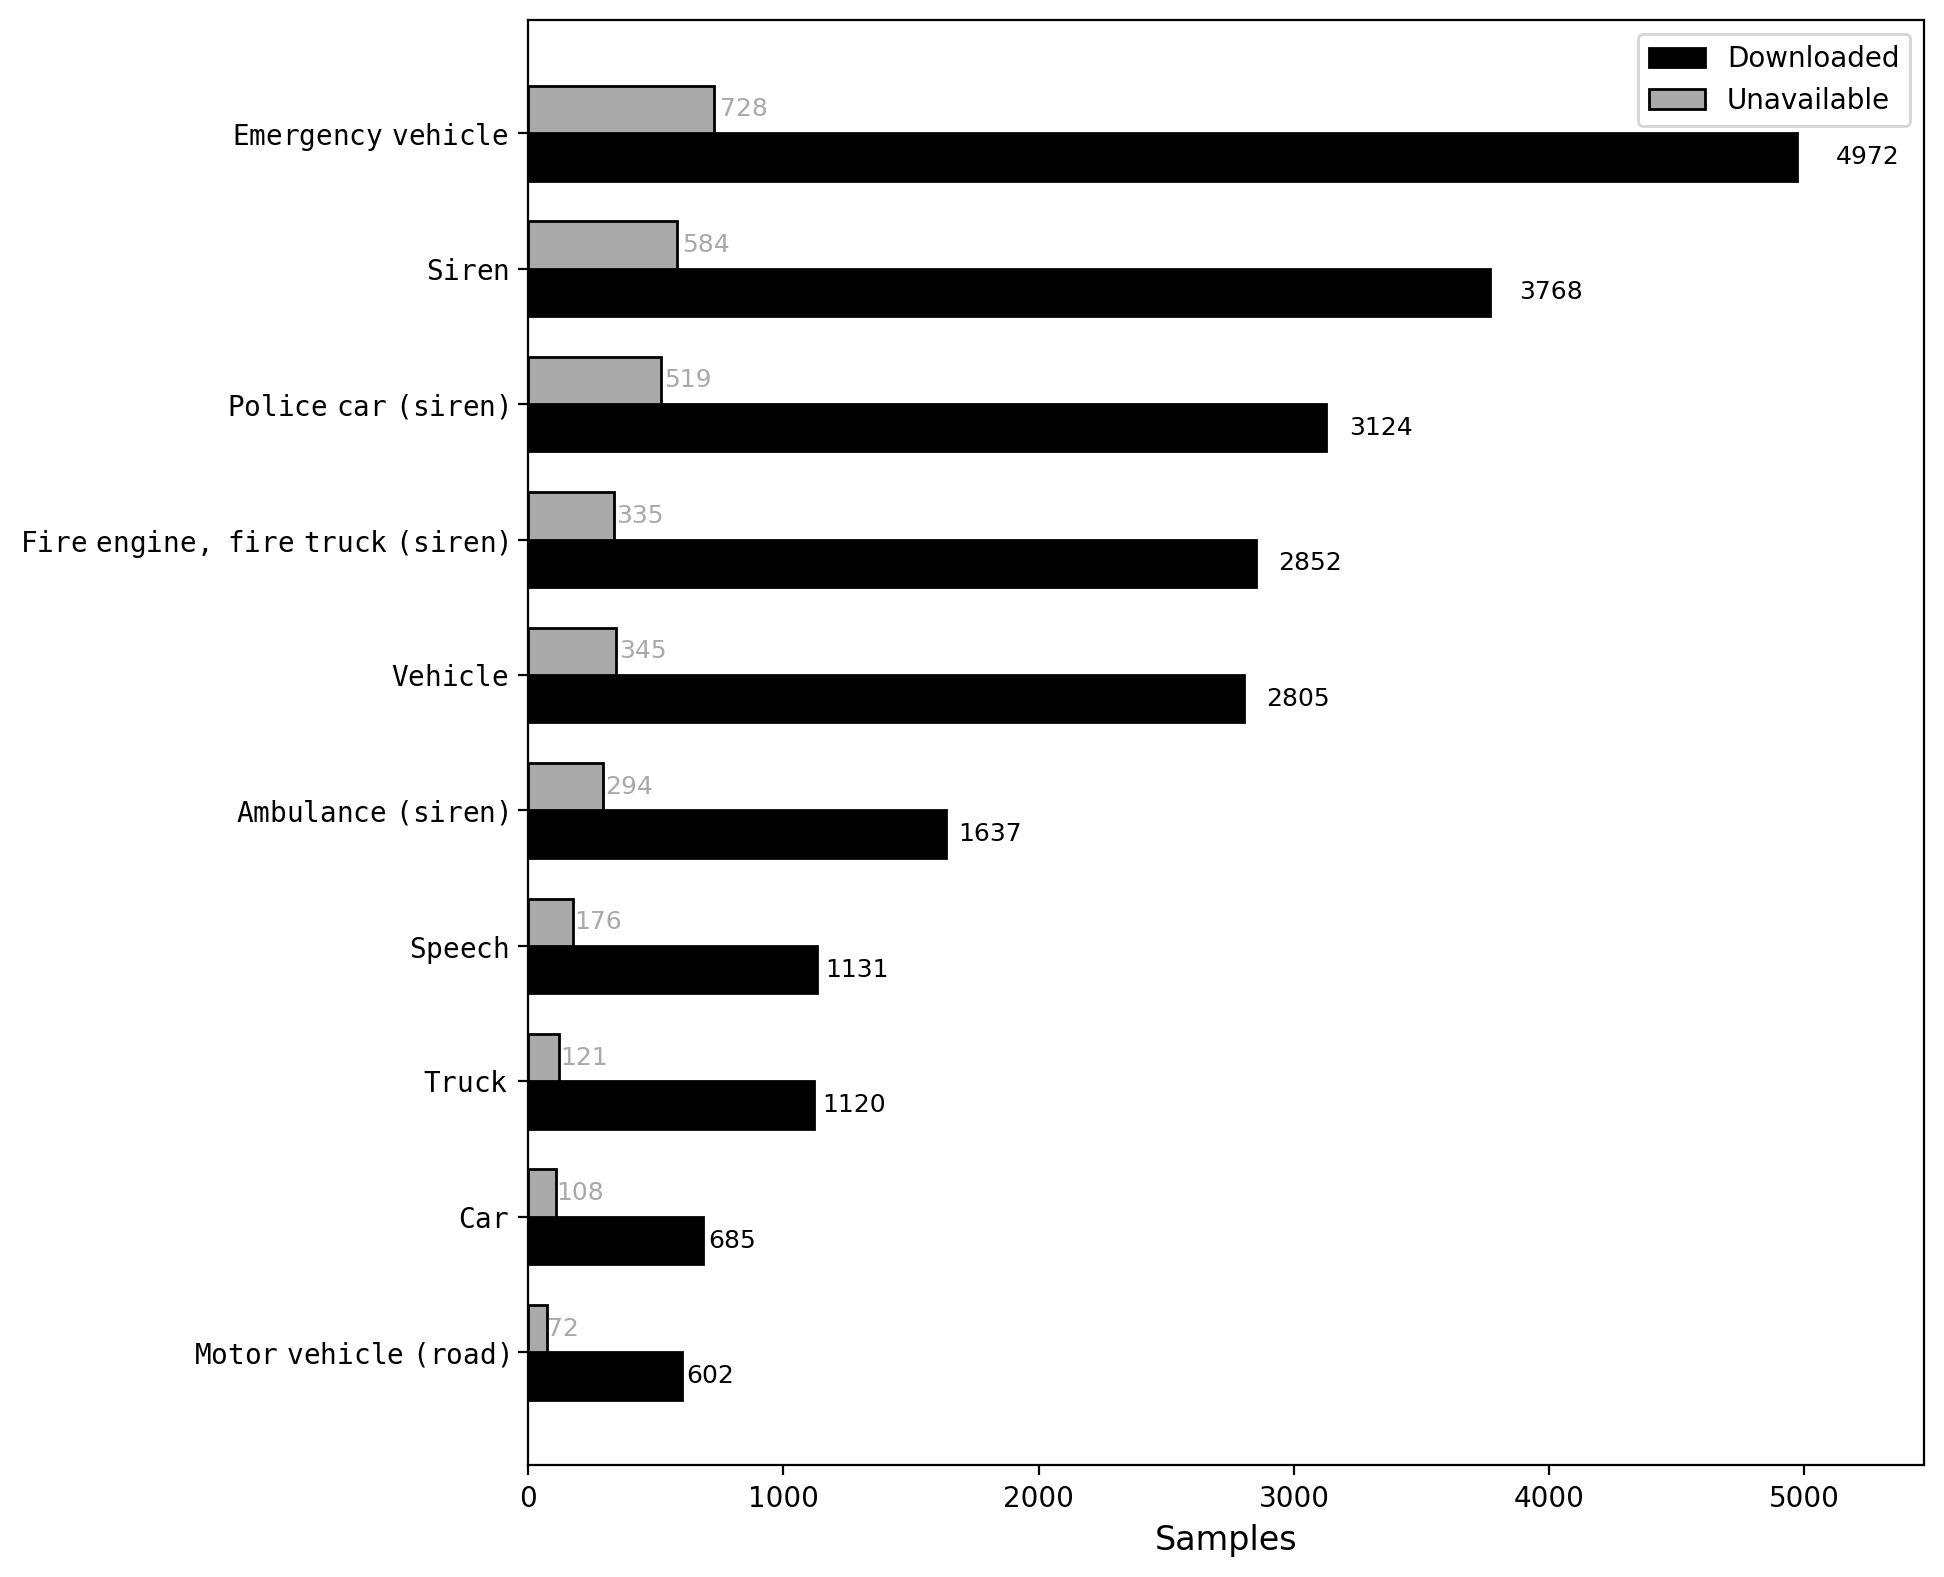

In [ ]:
# Top-10 Positives
path = "./drive/MyDrive/Colab Notebooks/AudioSet-Tools_paper/EV_Positives_downloaded_stats.json"
plot_labels_histogram(path, threshold=10, save_fig=True)

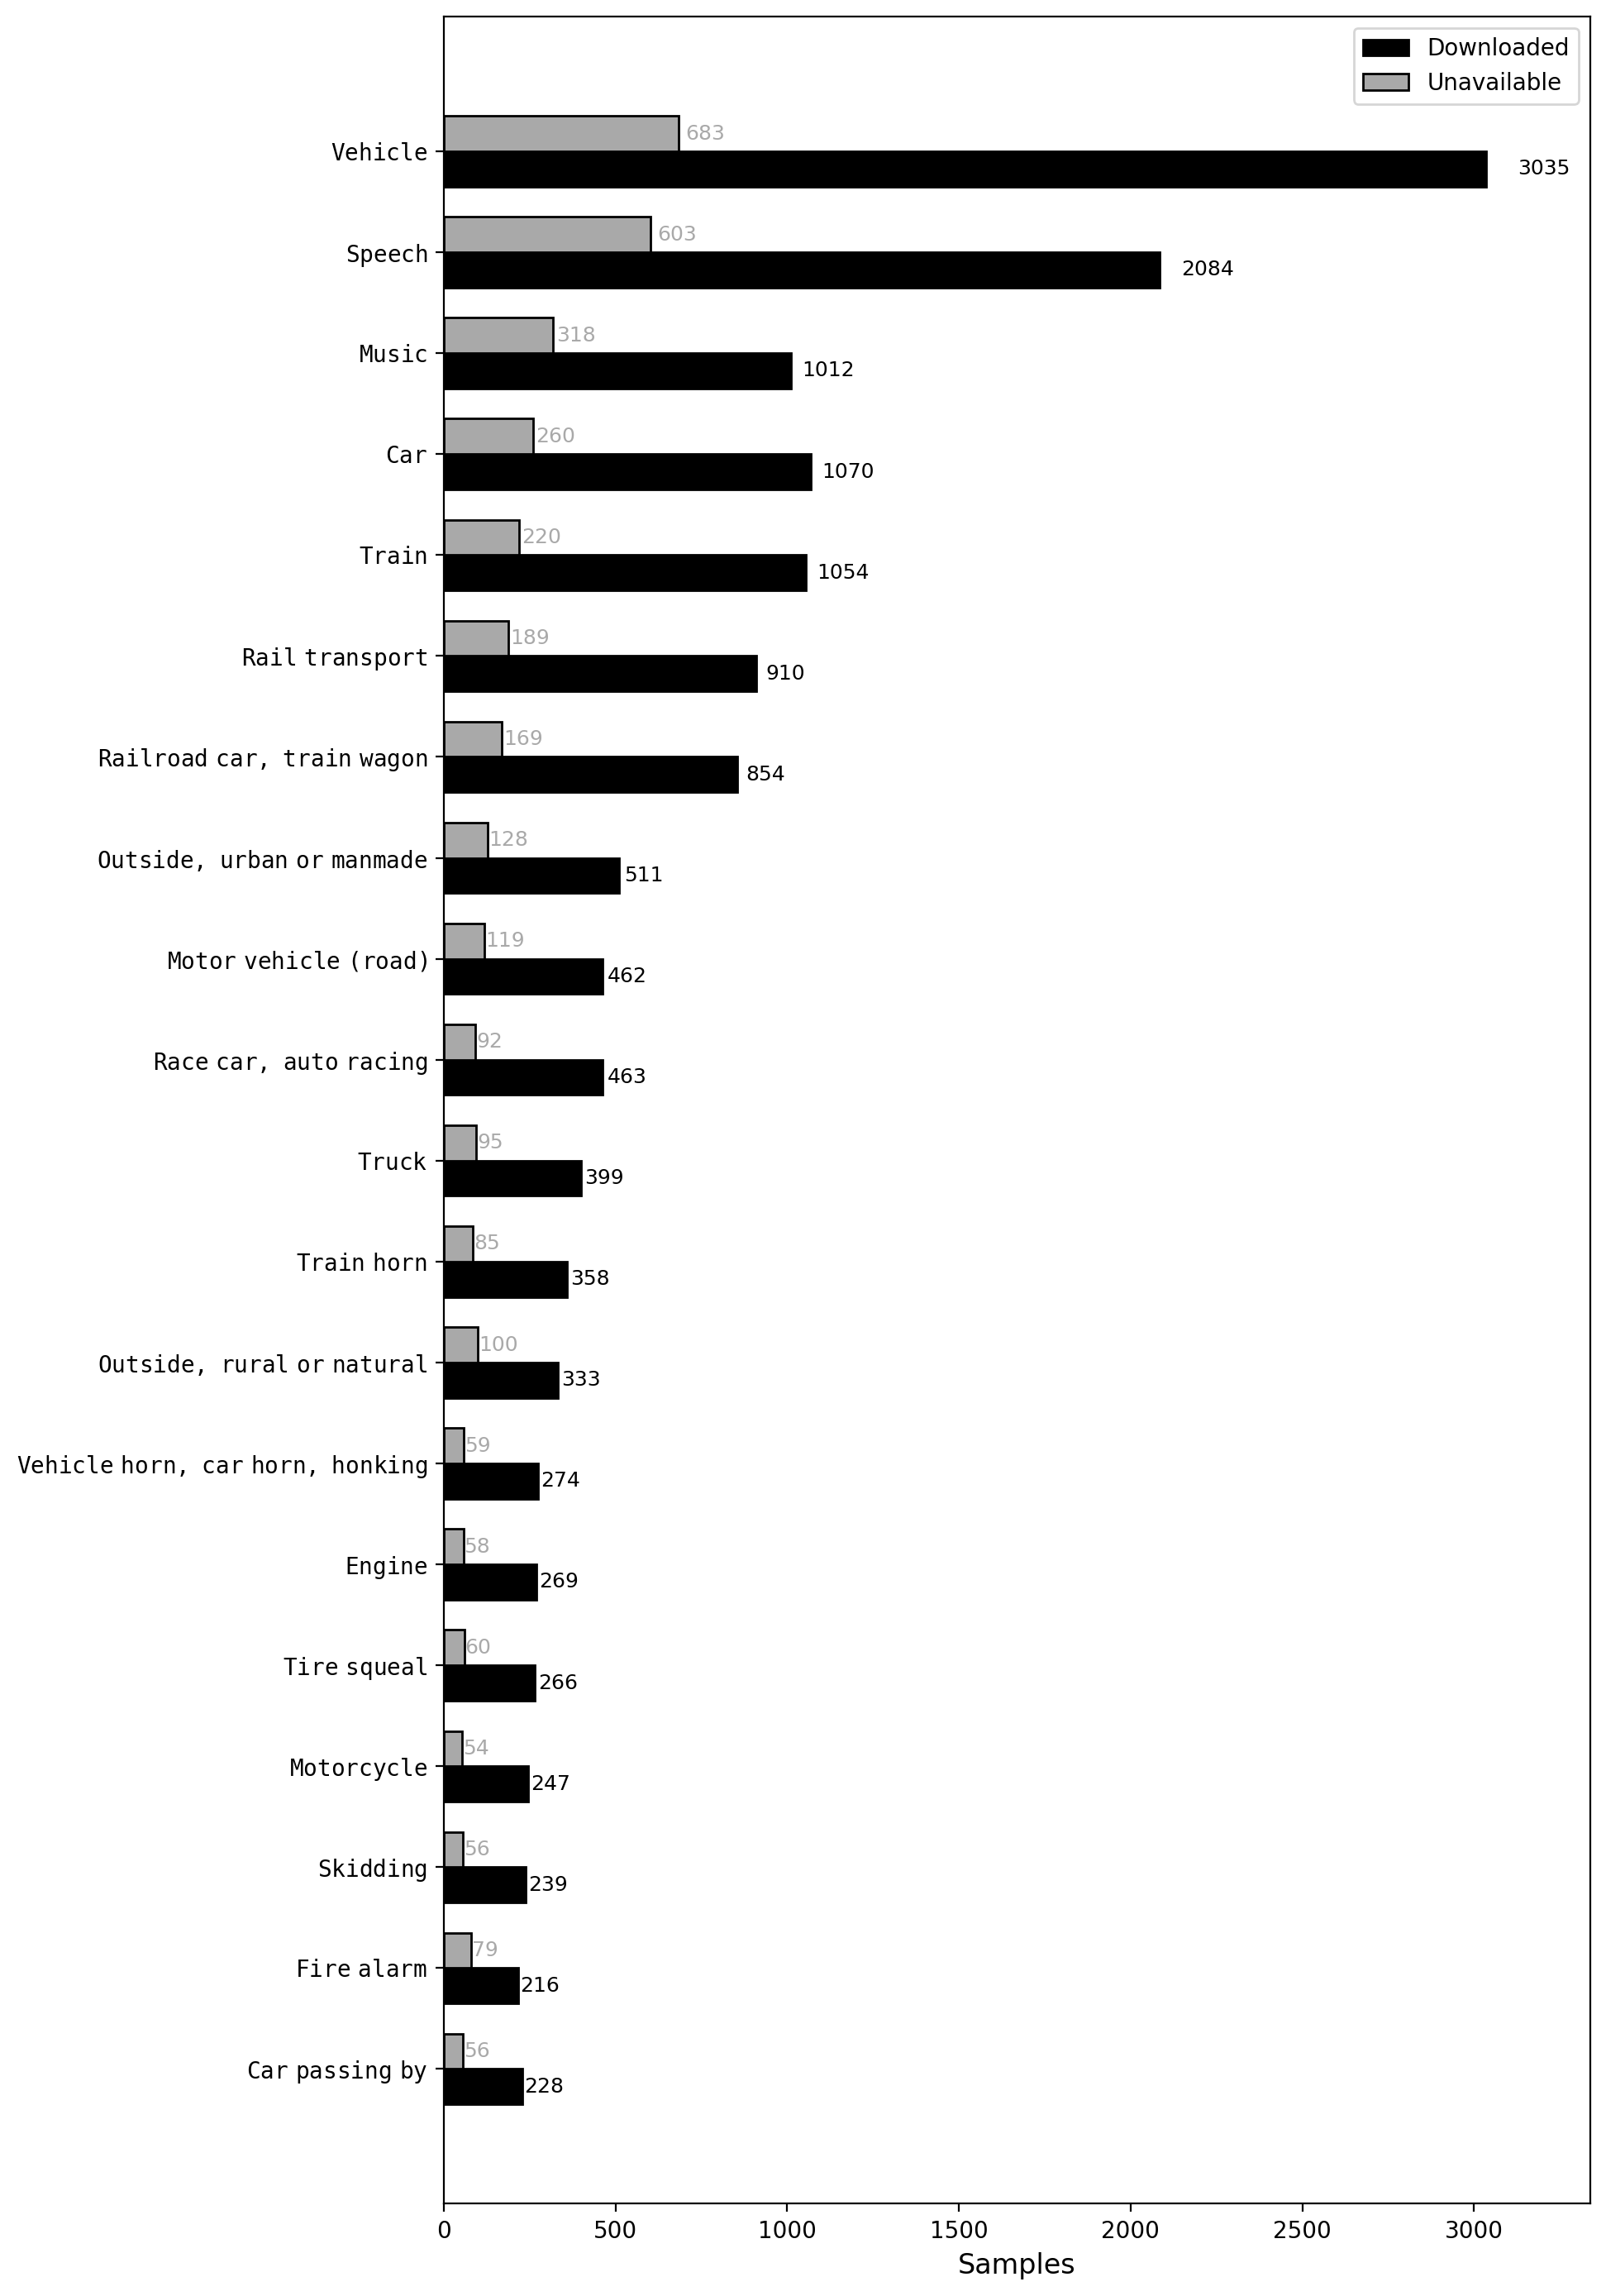

In [ ]:
# Top-20 Negatives
path = "./drive/MyDrive/Colab Notebooks/AudioSet-Tools_paper/EV_Negatives_downloaded_stats.json"
plot_labels_histogram(path, threshold=20, save_fig=True)

# Taxonomy Graphs

## Setup

In [ ]:
!git clone https://github.com/tpt-adasp/salt.git
%cd ./salt/py-salt
!ls

Cloning into 'salt'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 108 (delta 41), reused 93 (delta 29), pack-reused 0 (from 0)
Receiving objects: 100% (108/108), 2.51 MiB | 5.34 MiB/s, done.
Resolving deltas: 100% (41/41), done.
/content/salt/py-salt
assets	docs  notebooks  py_salt  README.md  setup.py


In [ ]:
# Correct comma after numpy requirement definition in setup.py
!pip install .

Processing /content/salt/py-salt
  Preparing metadata (setup.py) ... done
  Created wheel for py-salt: filename=py_salt-0.0.1-py3-none-any.whl size=1158 sha256=cccc3c8baebee490e20c543dd38c809a8ba0a8d355fb77f2f1f8796af866c81e
  Stored in directory: /root/.cache/pip/wheels/0b/c2/1d/d80c277fd3148162c2393cafb019c8d4038d0b7a0f054336f7
Successfully built py-salt


In [ ]:
from py_salt import dataset_info, event_mapping

In [ ]:
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 18 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgail18 amd64 2.24.33-2ubuntu2.1 [15.9 kB]
Get:4 http://archive.ubun

In [ ]:
dataset_info.Audioset().get_info(), dataset_info.Freesound50k().get_info(), dataset_info.Esc50().get_info(), dataset_info.UrbanSound8k().get_info()

({'name': 'AudioSet',
  'mapping_id': 'Audioset',
  'url': 'https://research.google.com/audioset/',
  'subset_of': 'None',
  'description': '2,084,320 human-labeled 10-second sound clips drawn from YouTube'},
 {'name': 'FreeSound 50k',
  'mapping_id': 'Freesound50k',
  'url': 'https://annotator.freesound.org/fsd/release/FSD50K/',
  'subset_of': 'None',
  'description': 'Strong annoatation of AudioSet.'},
 {'name': 'ESC-50',
  'mapping_id': 'Esc50',
  'url': 'https://github.com/karolpiczak/ESC-50/',
  'subset_of': 'None',
  'description': 'Labeled collection of 2000 environmental audio recordings.'},
 {'name': 'UrbanSound8k',
  'mapping_id': 'UrbanSound8k',
  'url': 'https://urbansounddataset.weebly.com/urbansound8k.html',
  'subset_of': 'None',
  'description': '8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes.'})

In [ ]:
positives = ['Emergency vehicle',
             'Police car (siren)',
             'Ambulance (siren)',
             'Fire engine, fire truck (siren)']
negatives = ['Car',                                # Vehicles Sounds (CONTAINER)
             'Car passing by',
             'Power windows, electric windows',
             'Tire squeal',
             'Motor vehicle (road)',  			   # CONTAINER
             'Truck',  							   # CONTAINER
             'Air brake',
             'Ice cream truck, ice cream van',
             'Bus',
             'Motorcycle',
             'Skidding',
             'Race car, auto racing',
             'Bicycle', 						   # CONTAINER
             'Train',							   # CONTAINER
             'Rail transport', 					   # CONTAINER
             'Train wheels squealing',
             'Railroad car, train wagon',
             'Skateboard',
             'Traffic noise, roadway noise',       # Environments -------------																			# Environments
             'Outside, rural or natural',
             'Outside, urban or manmade',
             'Car alarm',                          # Alarms -------------------                																					# Alarms
             'Vehicle horn, car horn, honking',	   # CONTAINER
             'Bicycle bell',
             'Train horn',
             'Train whistle',
             'Foghorn',
             'Toot',
             'Reversing beeps',
             'Beep, bleep',
             'Civil defense siren',
             'Alarm',								# CONTAINER
             'Smoke detector, smoke alarm',
             'Fire alarm',
             'Buzzer',
             'Speech',                             # Others (CONTAINERS) ------                        																					# Others (statistically relevant)
             'Music',
             'Singing',
             'Engine']

## Standardized Positive Labels

In [ ]:
e = event_mapping.EventExplorer()

In [ ]:
std_labels = ['emergency_vehicle', 'siren_ringing']

for std_label in std_labels:
    e.get_mapping_for_std_label(std_label)

    parent = e.get_parent_label_for_std_label(std_label)
    siblings = e.get_siblings_labels_for_std_label(std_label)
    children = e.get_children_labels_for_std_label(std_label)
    print('Parent label(s):', parent)
    print('Sibling label(s):', siblings)
    print('Children label(s):', children)

    coarse_labels = e.get_coarse_labels_for_std_label(std_label)
    fine_labels = e.get_fine_labels_for_std_label(std_label)
    print('Coarse label(s):', coarse_labels)
    print('Fine label(s):', fine_labels)
    print('-----------------------------------------------------------------------')

Parent label(s): road_vehicle
Sibling label(s): {'road_vehicle': ['car', 'motorcycle', 'large_vehicle', 'engine_accelerating', 'vehicle_passing_by', 'brakes_squeaking', 'vehicle_horn']}
Children label(s): ['vehicle_siren_ringing']
Coarse label(s): ['vehicle', 'road_vehicle', 'sound_of_things']
Fine label(s): ['vehicle_siren_ringing', 'fire_truck_siren_ringing', 'police_car_siren_ringing', 'ambulance_siren_ringing']
-----------------------------------------------------------------------
Parent label(s): alarm_signal
Sibling label(s): {'alarm_signal': ['error_signal', 'CO_detector', 'whistle', 'foghorn_ringing', 'buzzer_ringing', 'car_alarm_ringing', 'fire_alarm_ringing', 'vehicle_horn', 'air_horn_or_truck_horn', 'telephone', 'bicycle_bell', 'doorbell']}
Children label(s): ['civil_defense_siren_ringing', 'vehicle_siren_ringing', 'reverse_beeper']
Coarse label(s): ['alarm_signal', 'sound_of_things']
Fine label(s): ['civil_defense_siren_ringing', 'vehicle_siren_ringing', 'fire_truck_siren_

In [ ]:
e.get_paths_to_label('emergency_vehicle'), e.get_paths_to_label('siren_ringing')

([['sound_of_things', 'vehicle', 'road_vehicle', 'emergency_vehicle']],
 [['sound_of_things', 'alarm_signal', 'siren_ringing']])

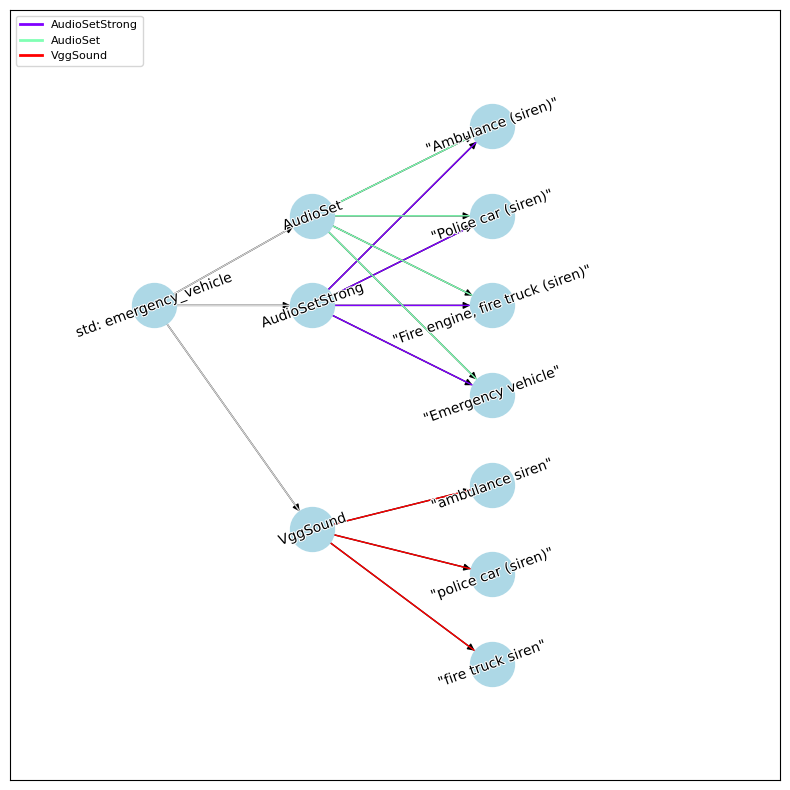

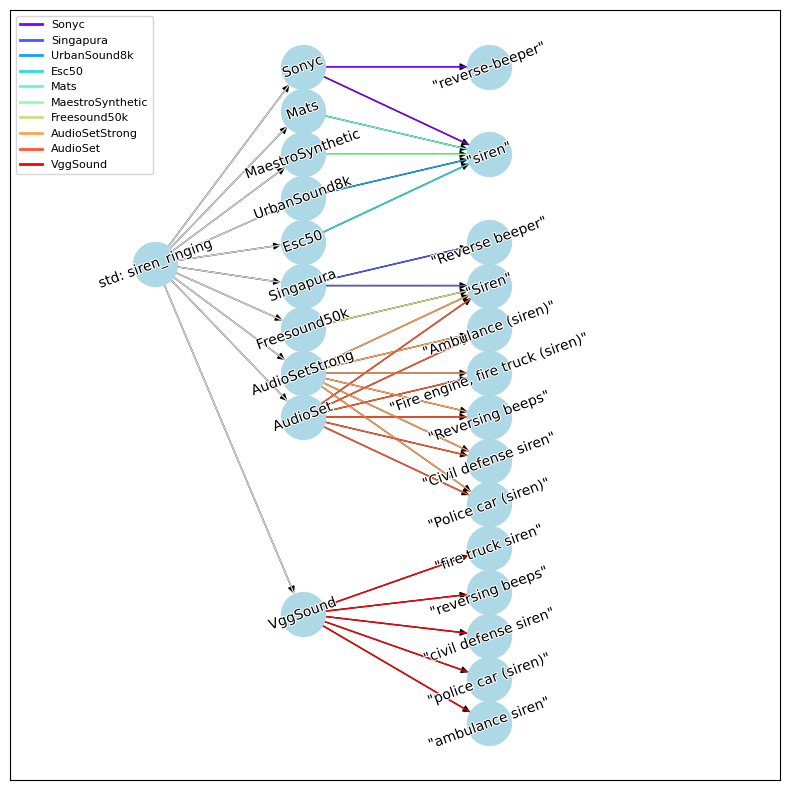

(None, None)

In [ ]:
e.plot_std_label_mapping('emergency_vehicle'), e.plot_std_label_mapping('siren_ringing')

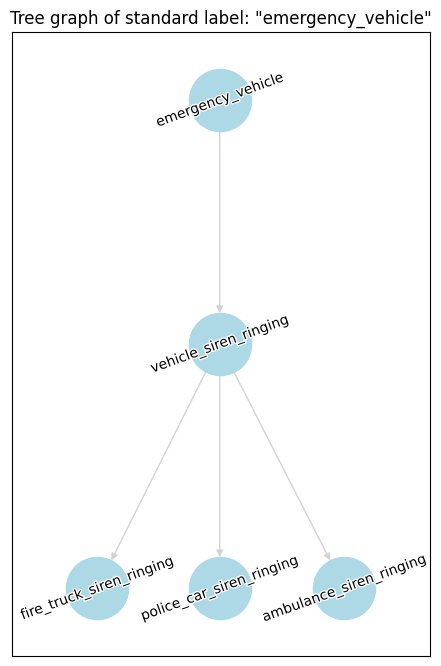

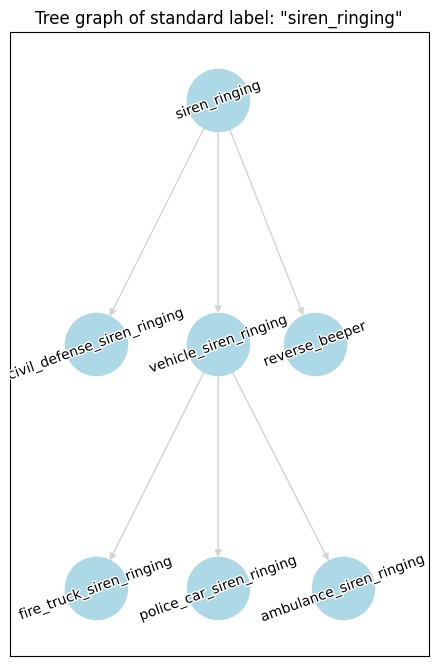

(None, None)

In [ ]:
e.plot_hierarchical_tree_graph('emergency_vehicle'), e.plot_hierarchical_tree_graph('siren_ringing')

In [ ]:
e.get_children_labels_for_std_label('emergency_vehicle'), e.get_children_labels_for_std_label('siren_ringing')

(['vehicle_siren_ringing'],
 ['civil_defense_siren_ringing', 'vehicle_siren_ringing', 'reverse_beeper'])

## AS-EV to FSD50K/ESC-50/UrbanSound8K

In [ ]:
from pprint import pprint as pp
e = event_mapping.EventExplorer()

### Positives

STANDARD LABEL: emergency_vehicle

AudioSet DATASET
['Emergency vehicle',
 'Ambulance (siren)',
 'Police car (siren)',
 'Fire engine, fire truck (siren)']

Freesound50k DATASET
No Correlation

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
No Correlation



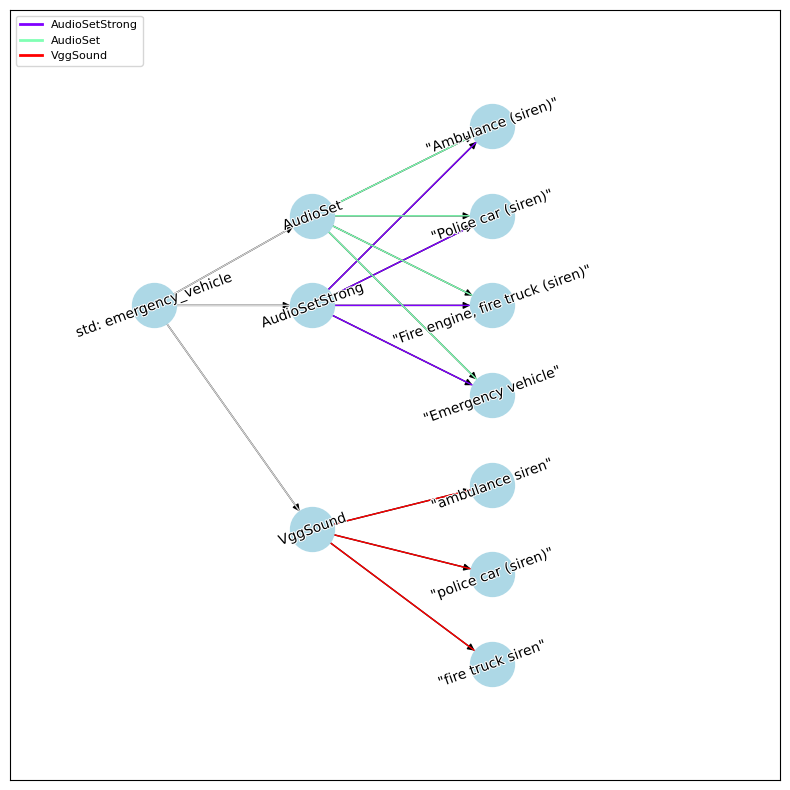

--------------------------------------------------------------------------------------
STANDARD LABEL: police_car_siren_ringing

AudioSet DATASET
['Police car (siren)']

Freesound50k DATASET
No Correlation

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
No Correlation



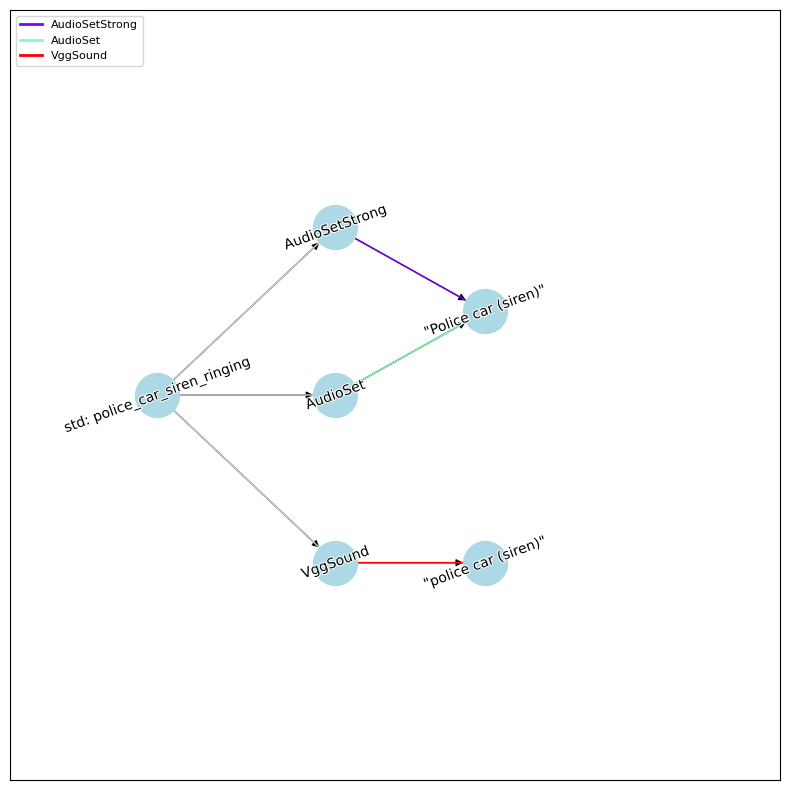

--------------------------------------------------------------------------------------
STANDARD LABEL: ambulance_siren_ringing

AudioSet DATASET
['Ambulance (siren)']

Freesound50k DATASET
No Correlation

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
No Correlation



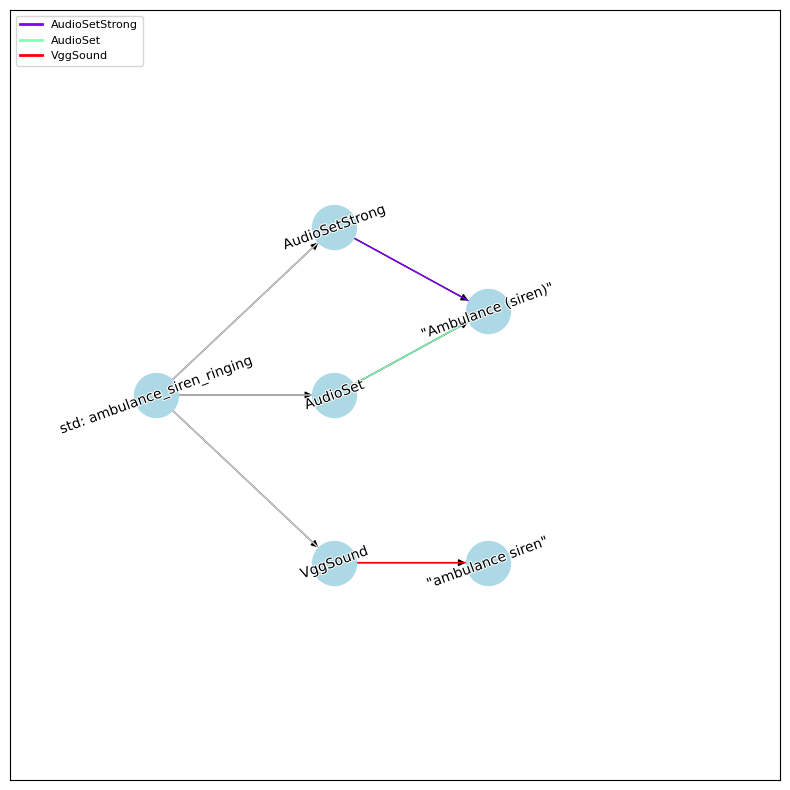

--------------------------------------------------------------------------------------
STANDARD LABEL: fire_truck_siren_ringing

AudioSet DATASET
['Fire engine, fire truck (siren)']

Freesound50k DATASET
No Correlation

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
No Correlation



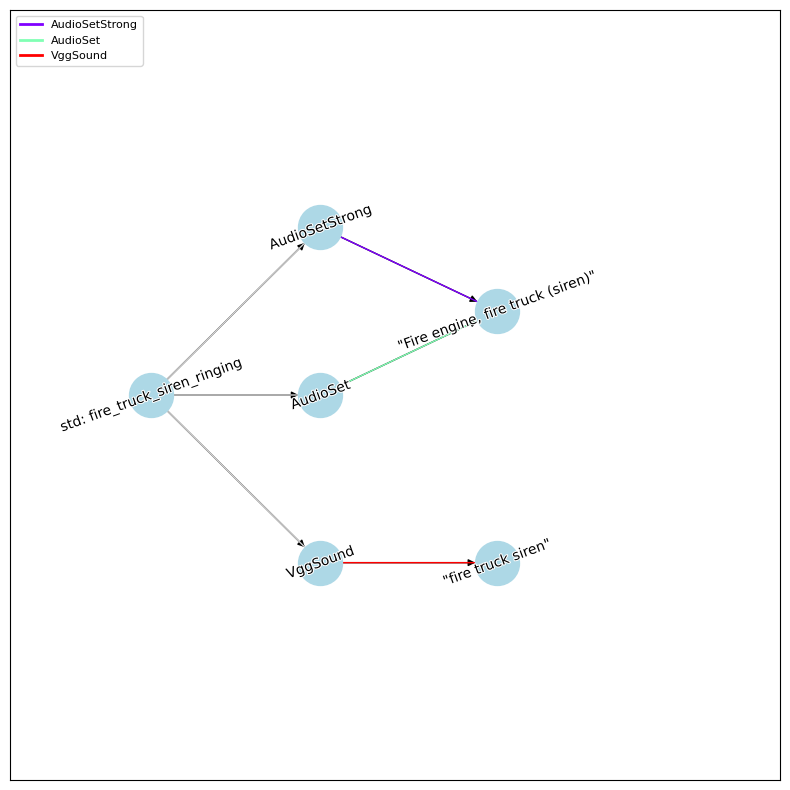

--------------------------------------------------------------------------------------


In [ ]:
for label in positives:
    dictionary = e.get_mapping_for_dataset_label(label)
    std_label = e.get_std_label_from_dataset_label(label)
    print(f'STANDARD LABEL: {std_label}')
    print()

    print('AudioSet DATASET')
    pp(dictionary['AudioSet'])
    print()
    print('Freesound50k DATASET')
    try:
        pp(dictionary['Freesound50k'])
    except:
        print('No Correlation')

    print()
    print('UrbanSound8k DATASET')
    try:
        pp(dictionary['UrbanSound8k'])
    except:
        print('No Correlation')

    print()
    print('ESC-50 DATASET')
    try:
        pp(dictionary['Esc50'])
    except:
        print('No Correlation')

    print()
    e.plot_std_label_mapping(std_label)
    print('--------------------------------------------------------------------------------------')

### Siren

In [ ]:
pp(e.get_mapping_for_dataset_label('siren'))
pp(e.get_std_label_from_dataset_label('siren'))

{'AudioSet': ['Siren',
              'Civil defense siren',
              'Police car (siren)',
              'Ambulance (siren)',
              'Fire engine, fire truck (siren)',
              'Reversing beeps'],
 'AudioSetStrong': ['Siren',
                    'Civil defense siren',
                    'Police car (siren)',
                    'Ambulance (siren)',
                    'Fire engine, fire truck (siren)',
                    'Reversing beeps'],
 'Esc50': ['siren'],
 'Freesound50k': ['Siren'],
 'MaestroSynthetic': ['siren'],
 'Mats': ['siren'],
 'Singapura': ['Siren', 'Reverse beeper'],
 'Sonyc': ['siren', 'reverse-beeper'],
 'UrbanSound8k': ['siren'],
 'VggSound': ['civil defense siren',
              'police car (siren)',
              'ambulance siren',
              'fire truck siren',
              'reversing beeps']}
'siren_ringing'


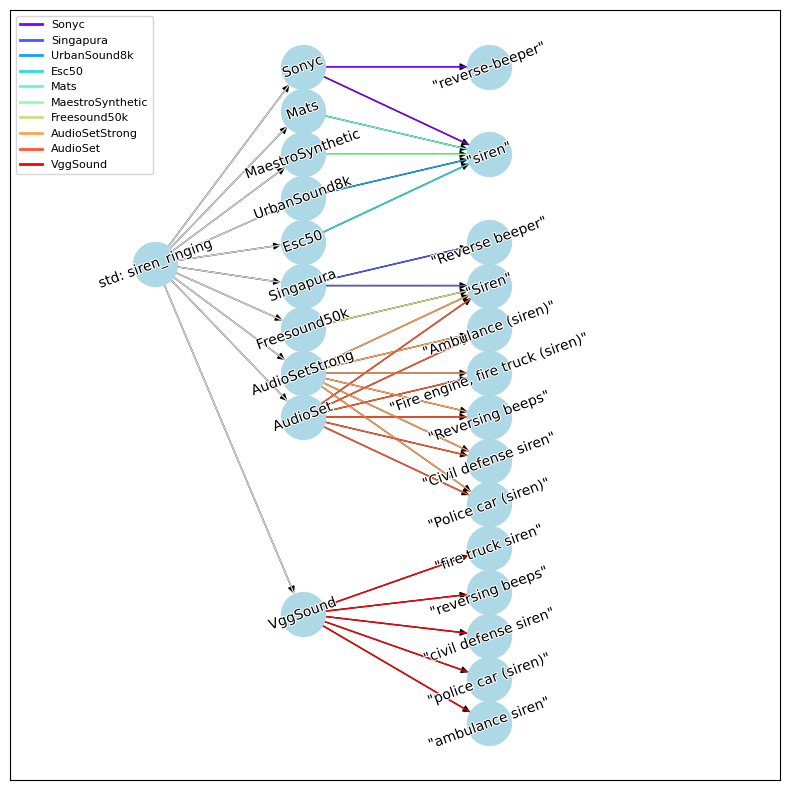

In [ ]:
e.plot_std_label_mapping('siren_ringing')

### Negatives

STANDARD LABEL: car

AudioSet DATASET
['Car',
 'Car passing by',
 'Race car, auto racing',
 'Tire squeal',
 'Skidding',
 'Power windows, electric windows',
 'Toot',
 'Vehicle horn, car horn, honking',
 'Car alarm']

Freesound50k DATASET
['Car',
 'Car_passing_by',
 'Race_car_and_auto_racing',
 'Vehicle_horn_and_car_horn_and_honking']

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
No Correlation



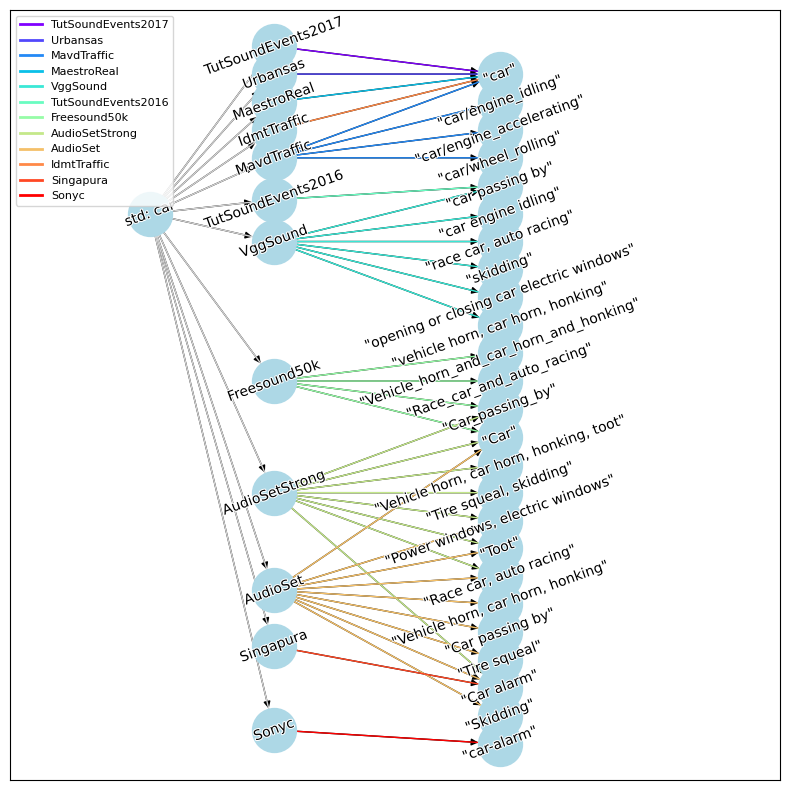

--------------------------------------------------------------------------------------
STANDARD LABEL: car_passing_by

AudioSet DATASET
['Car passing by']

Freesound50k DATASET
['Car_passing_by']

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
No Correlation



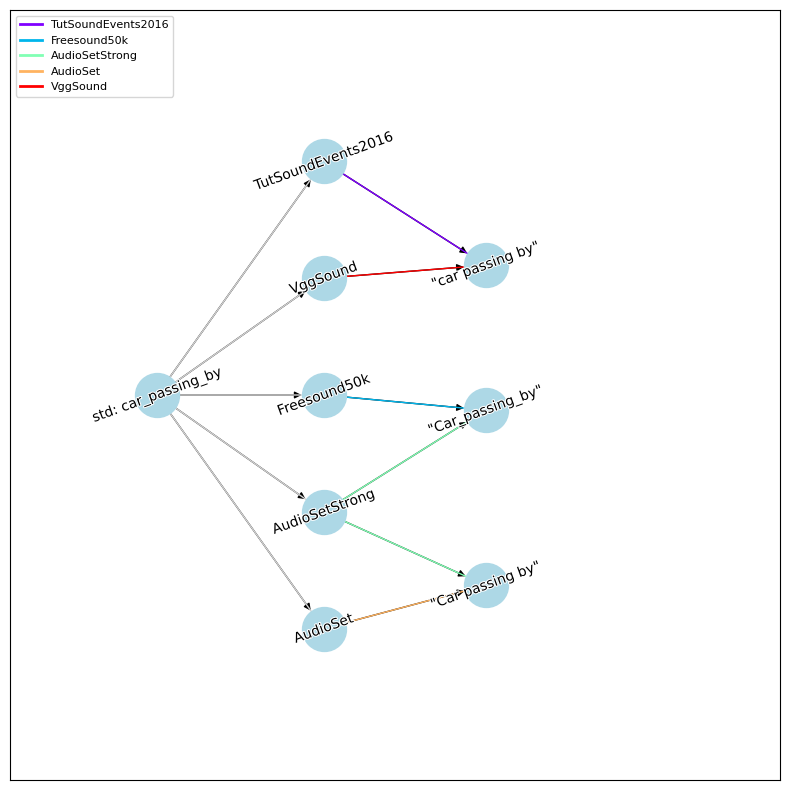

--------------------------------------------------------------------------------------
STANDARD LABEL: power_windows_electric windows

AudioSet DATASET
['Power windows, electric windows']

Freesound50k DATASET
No Correlation

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
No Correlation



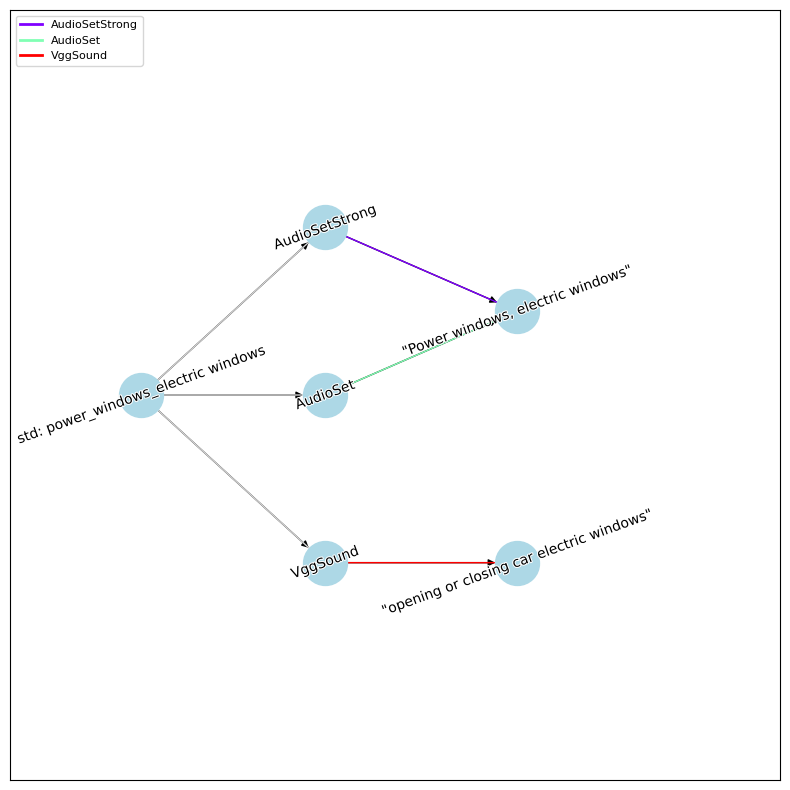

--------------------------------------------------------------------------------------
STANDARD LABEL: tire_squealing

AudioSet DATASET
['Tire squeal']

Freesound50k DATASET
No Correlation

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
No Correlation



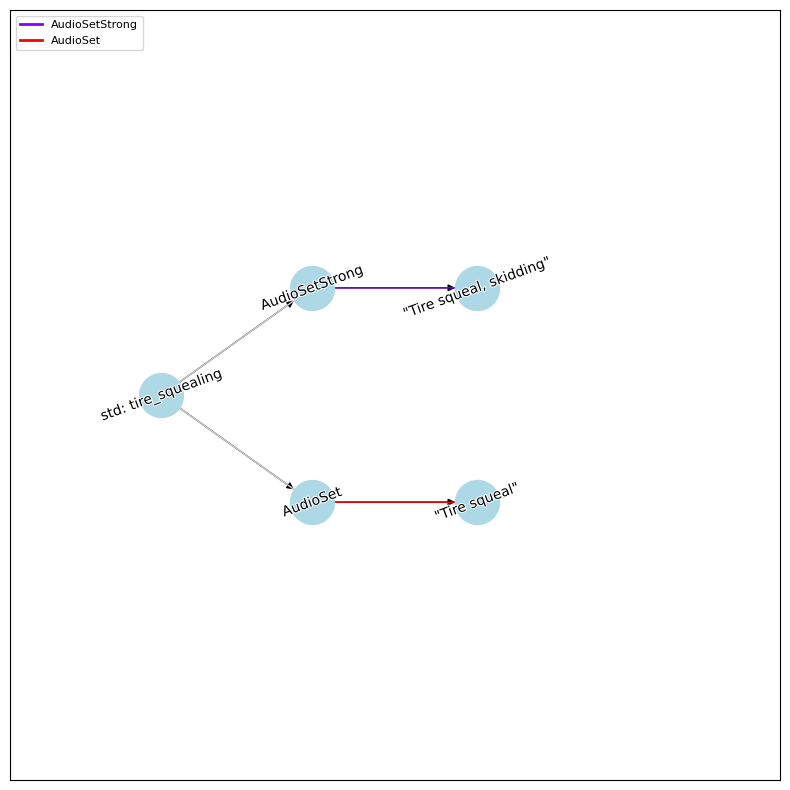

--------------------------------------------------------------------------------------
STANDARD LABEL: road_vehicle

AudioSet DATASET
['Accelerating, revving, vroom',
 'Air brake',
 'Air horn, truck horn',
 'Ambulance (siren)',
 'Bus',
 'Car',
 'Car alarm',
 'Car passing by',
 'Emergency vehicle',
 'Fire engine, fire truck (siren)',
 'Ice cream truck, ice cream van',
 'Motor vehicle (road)',
 'Motorcycle',
 'Police car (siren)',
 'Power windows, electric windows',
 'Race car, auto racing',
 'Reversing beeps',
 'Skidding',
 'Tire squeal',
 'Toot',
 'Truck',
 'Vehicle horn, car horn, honking']

Freesound50k DATASET
['Accelerating_and_revving_and_vroom',
 'Bus',
 'Car',
 'Car_passing_by',
 'Motor_vehicle_(road)',
 'Motorcycle',
 'Race_car_and_auto_racing',
 'Truck',
 'Vehicle_horn_and_car_horn_and_honking']

UrbanSound8k DATASET
['car_horn', 'engine_idling']

ESC-50 DATASET
['car_horn', 'engine']



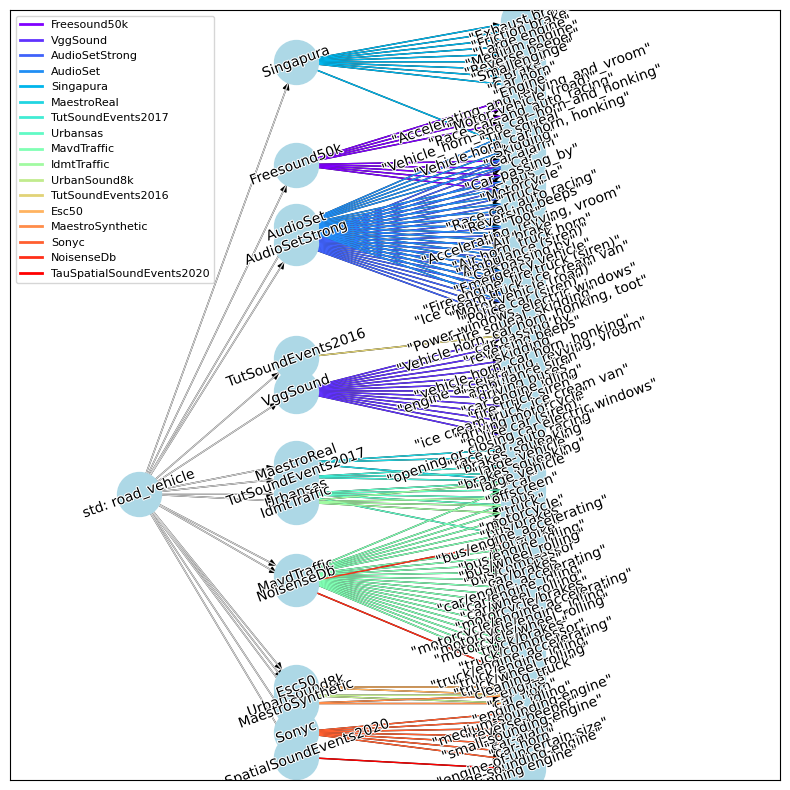

--------------------------------------------------------------------------------------
STANDARD LABEL: truck

AudioSet DATASET
['Truck',
 'Ice cream truck, ice cream van',
 'Reversing beeps',
 'Air horn, truck horn',
 'Air brake']

Freesound50k DATASET
['Truck']

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
No Correlation



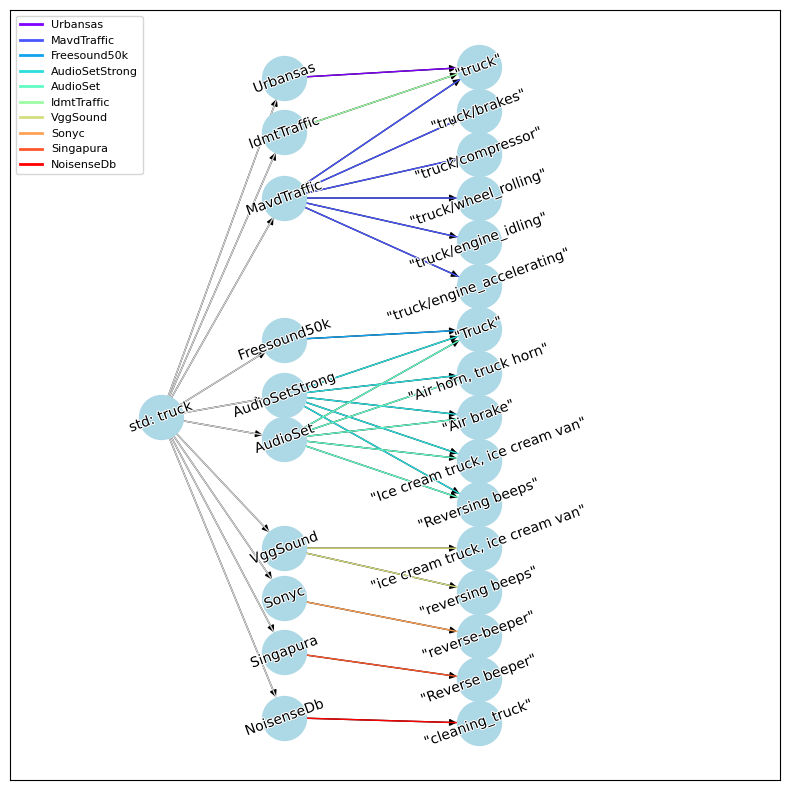

--------------------------------------------------------------------------------------
STANDARD LABEL: air_brake

AudioSet DATASET
['Air brake']

Freesound50k DATASET
No Correlation

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
No Correlation



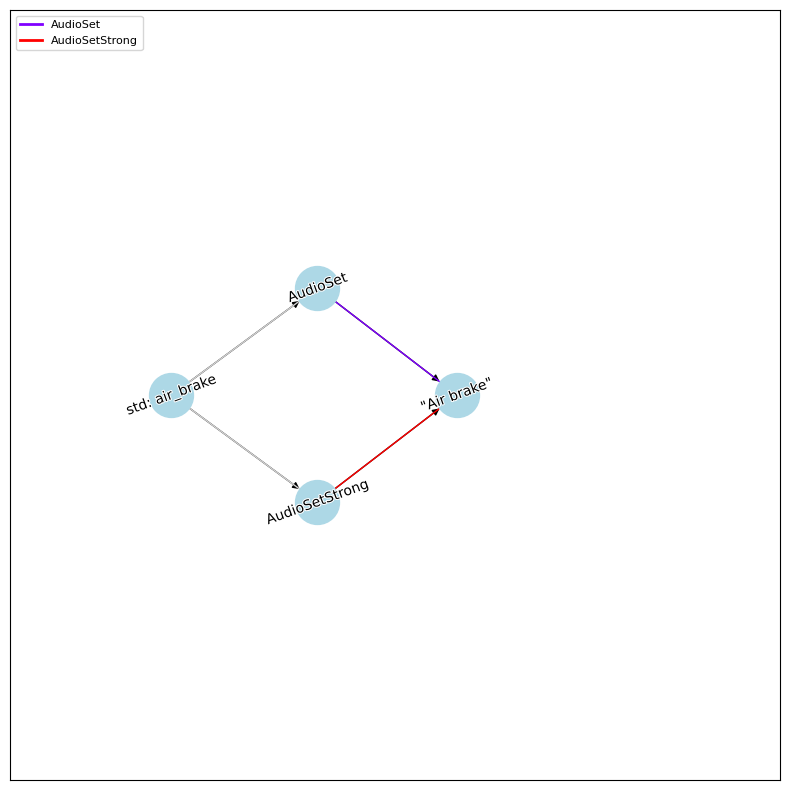

--------------------------------------------------------------------------------------
STANDARD LABEL: ice_cream_truck

AudioSet DATASET
['Ice cream truck, ice cream van']

Freesound50k DATASET
No Correlation

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
No Correlation



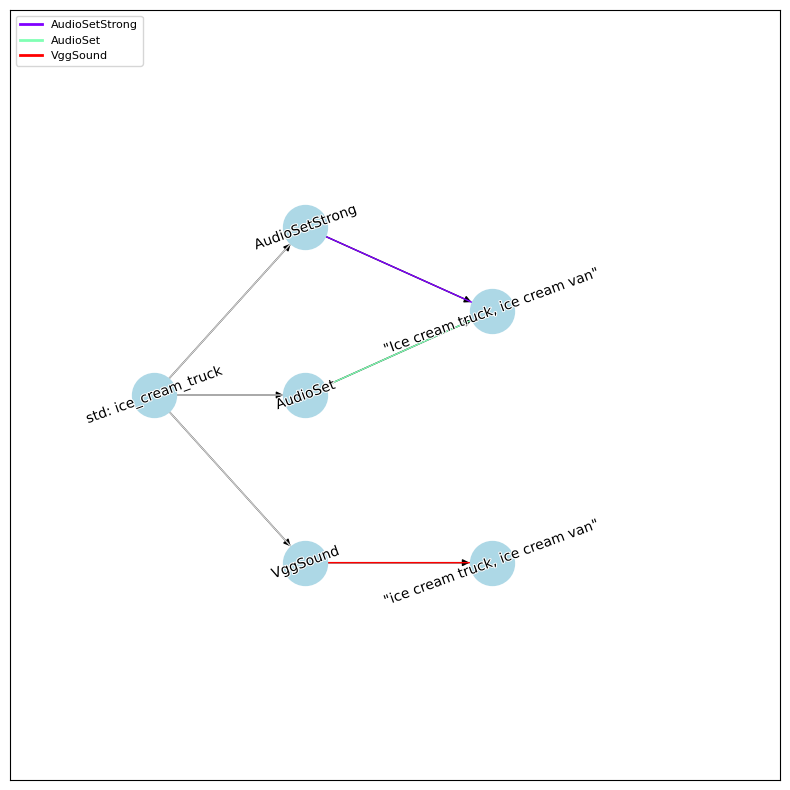

--------------------------------------------------------------------------------------
STANDARD LABEL: bus

AudioSet DATASET
['Bus']

Freesound50k DATASET
['Bus']

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
No Correlation



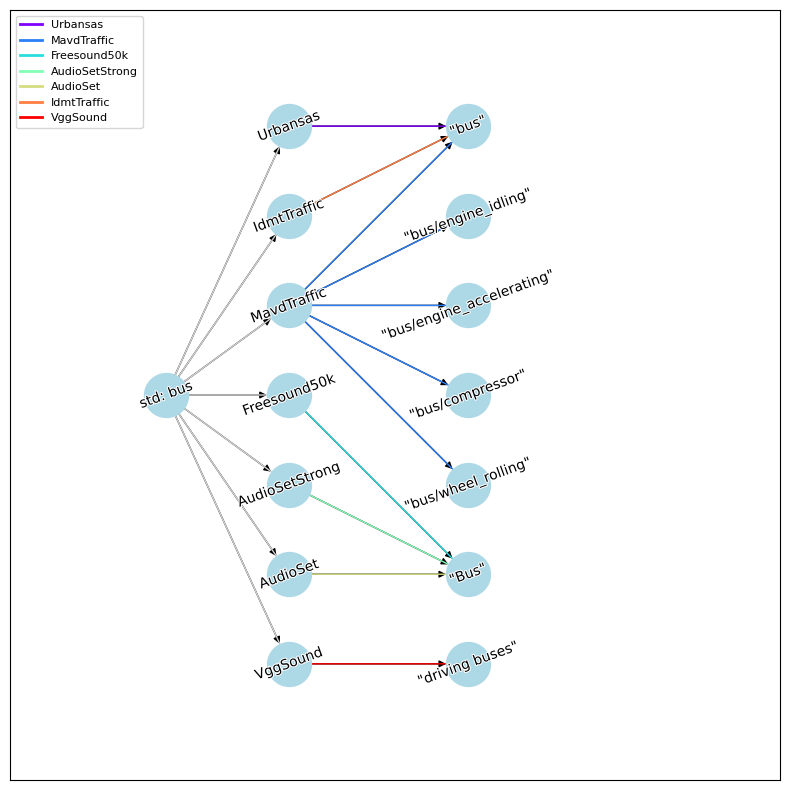

--------------------------------------------------------------------------------------
STANDARD LABEL: motorcycle

AudioSet DATASET
['Motorcycle']

Freesound50k DATASET
['Motorcycle']

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
No Correlation



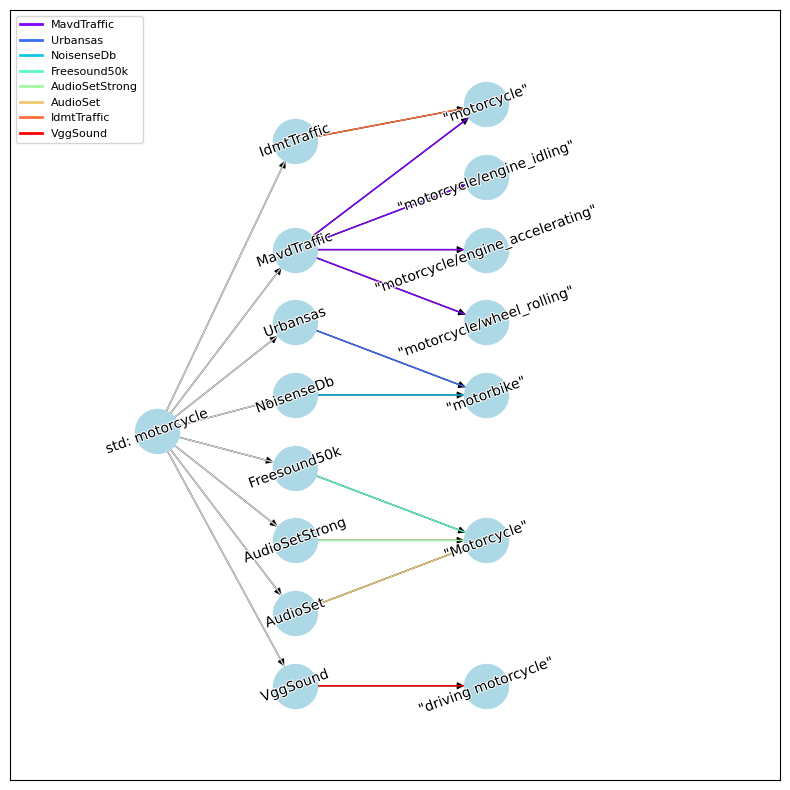

--------------------------------------------------------------------------------------
STANDARD LABEL: car_skidding

AudioSet DATASET
['Skidding', 'Tire squeal']

Freesound50k DATASET
No Correlation

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
No Correlation



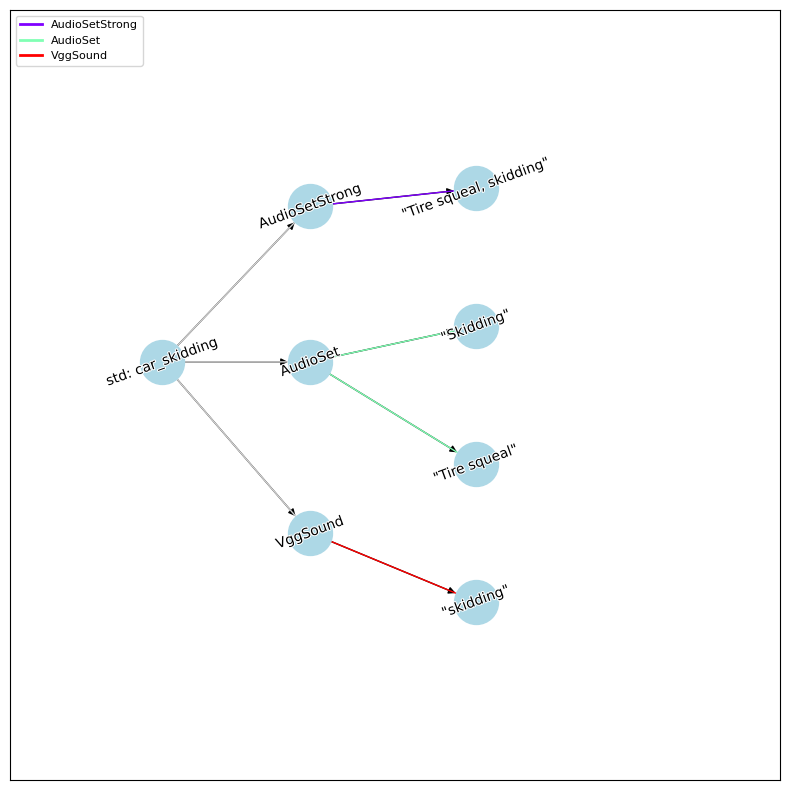

--------------------------------------------------------------------------------------
STANDARD LABEL: race_car

AudioSet DATASET
['Race car, auto racing']

Freesound50k DATASET
['Race_car_and_auto_racing']

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
No Correlation



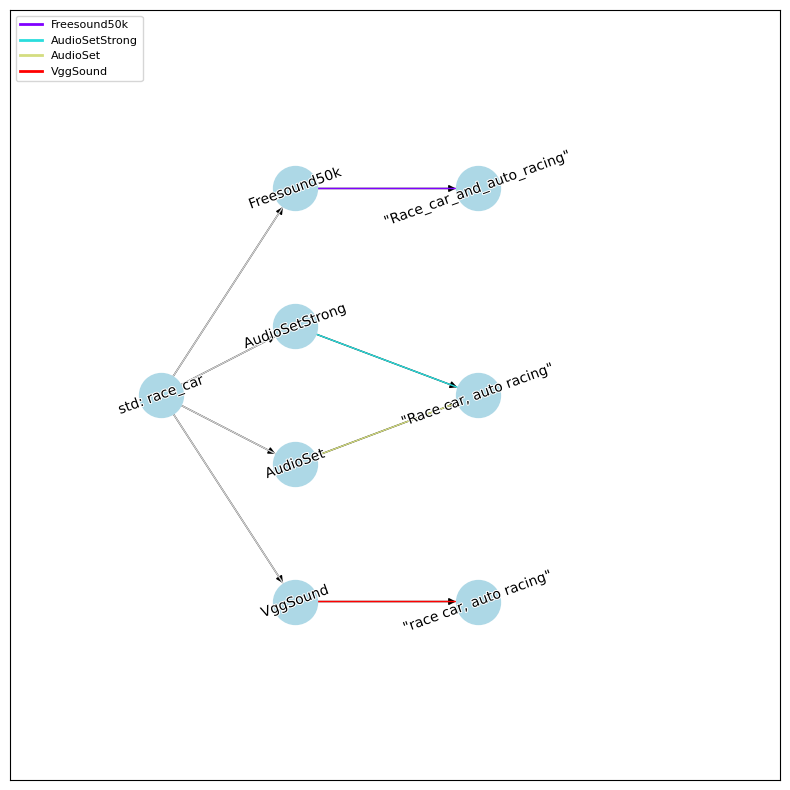

--------------------------------------------------------------------------------------
STANDARD LABEL: bicycle

AudioSet DATASET
['Bicycle']

Freesound50k DATASET
['Bicycle']

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
No Correlation



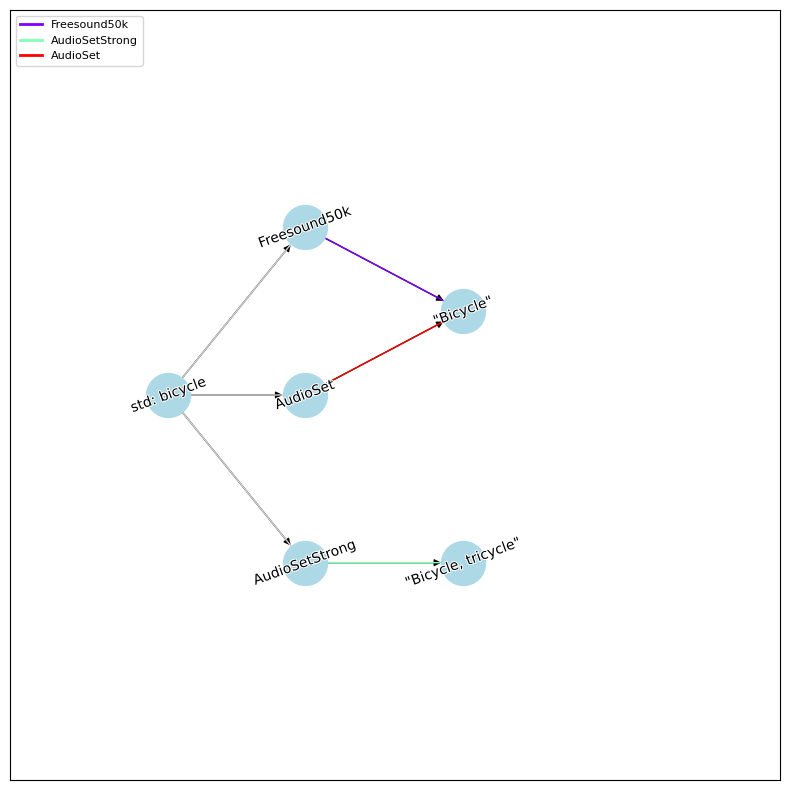

--------------------------------------------------------------------------------------
STANDARD LABEL: train

AudioSet DATASET
['Train', 'Train horn', 'Train wheels squealing', 'Train whistle']

Freesound50k DATASET
['Train']

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
['train']



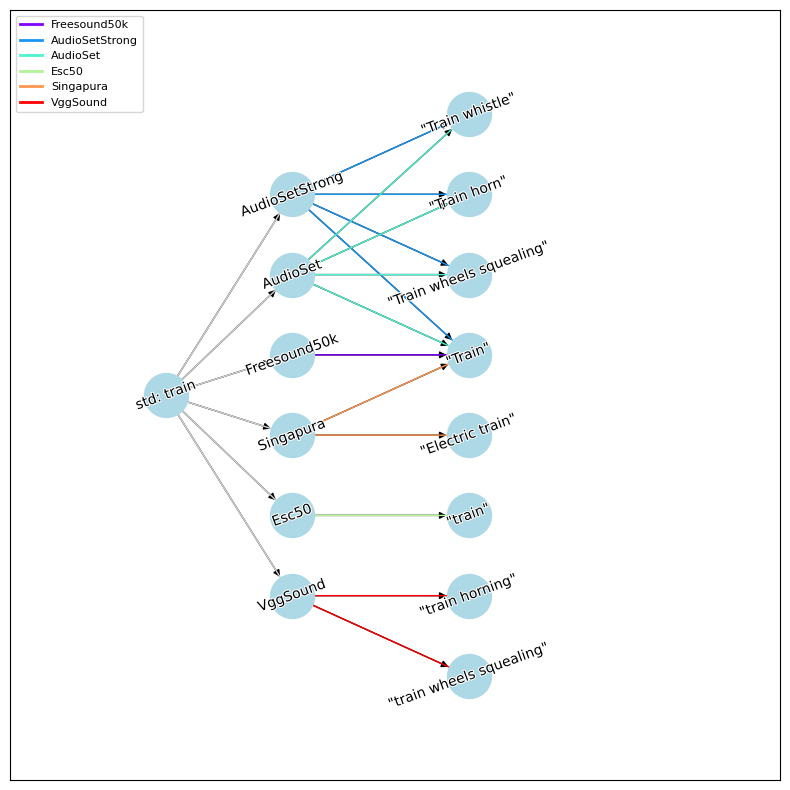

--------------------------------------------------------------------------------------
STANDARD LABEL: rail_transport

AudioSet DATASET
['Rail transport',
 'Train',
 'Subway, metro, underground',
 'Railroad car, train wagon',
 'Train horn',
 'Train wheels squealing',
 'Train whistle']

Freesound50k DATASET
['Rail_transport', 'Train', 'Subway_and_metro_and_underground']

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
['train']



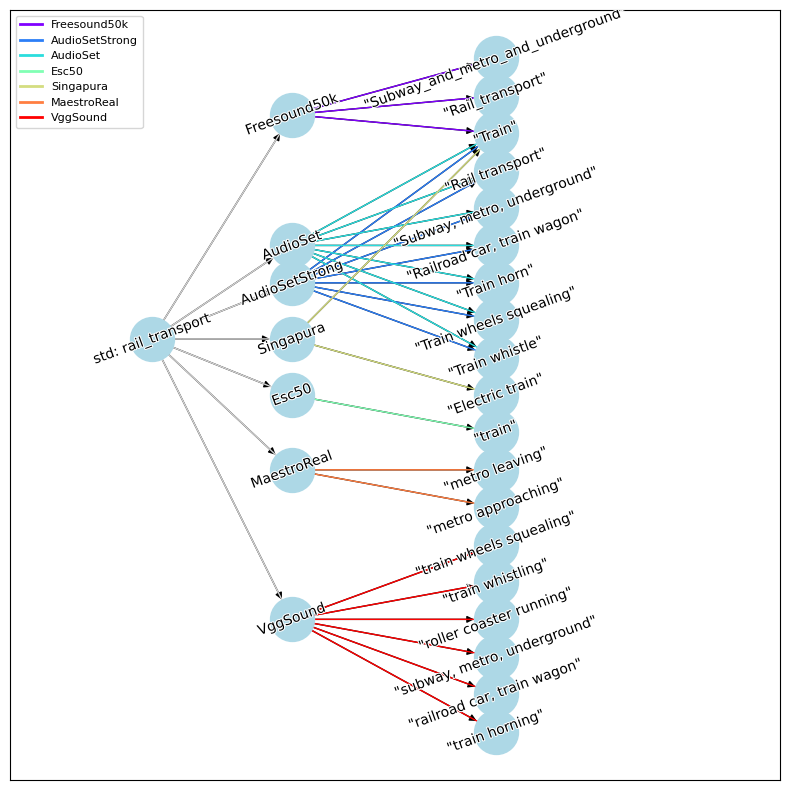

--------------------------------------------------------------------------------------
STANDARD LABEL: train_wheels_squealing

AudioSet DATASET
['Train wheels squealing']

Freesound50k DATASET
No Correlation

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
No Correlation



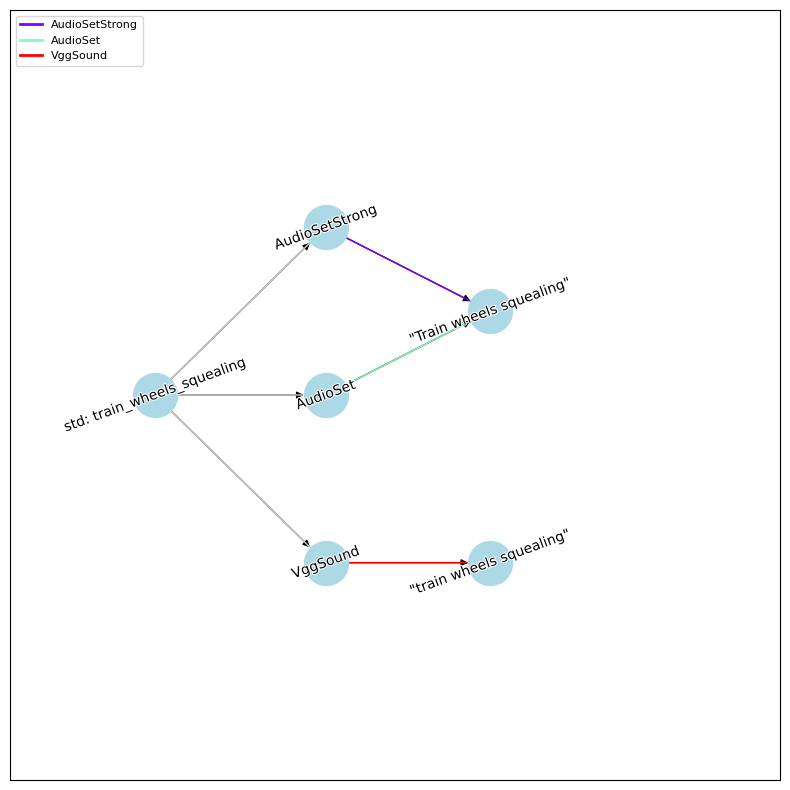

--------------------------------------------------------------------------------------
STANDARD LABEL: railroad_car_or_train_wagon

AudioSet DATASET
['Railroad car, train wagon']

Freesound50k DATASET
No Correlation

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
No Correlation



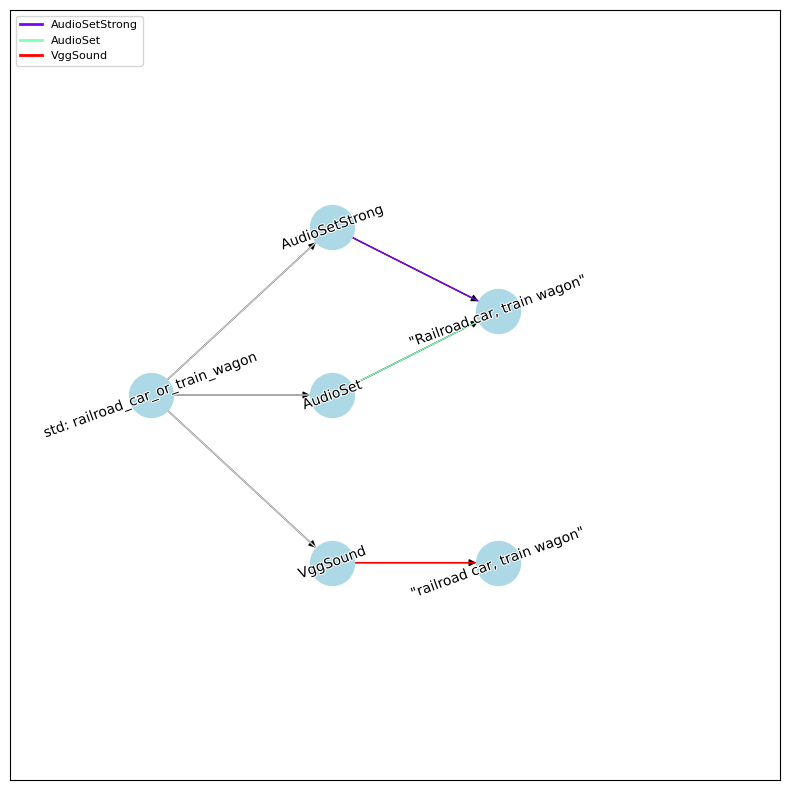

--------------------------------------------------------------------------------------
STANDARD LABEL: skateboard

AudioSet DATASET
['Skateboard']

Freesound50k DATASET
['Skateboard']

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
No Correlation



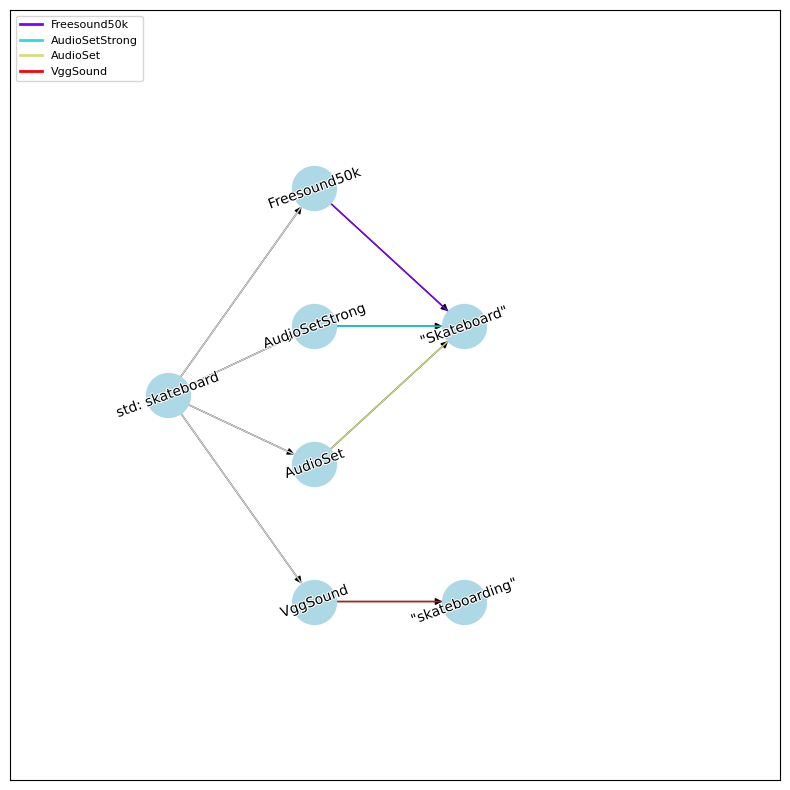

--------------------------------------------------------------------------------------
STANDARD LABEL: traffic_noise

AudioSet DATASET
['Traffic noise, roadway noise']

Freesound50k DATASET
['Traffic_noise_and_roadway_noise']

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
No Correlation



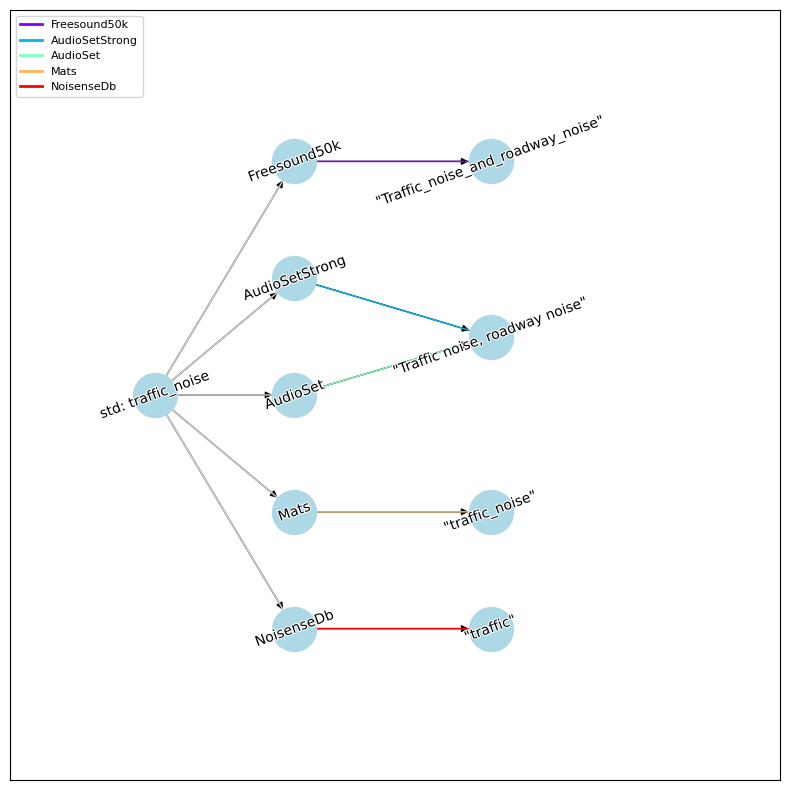

--------------------------------------------------------------------------------------
STANDARD LABEL: outdoor_rural_or_natural

AudioSet DATASET
['Outside, rural or natural']

Freesound50k DATASET
No Correlation

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
No Correlation



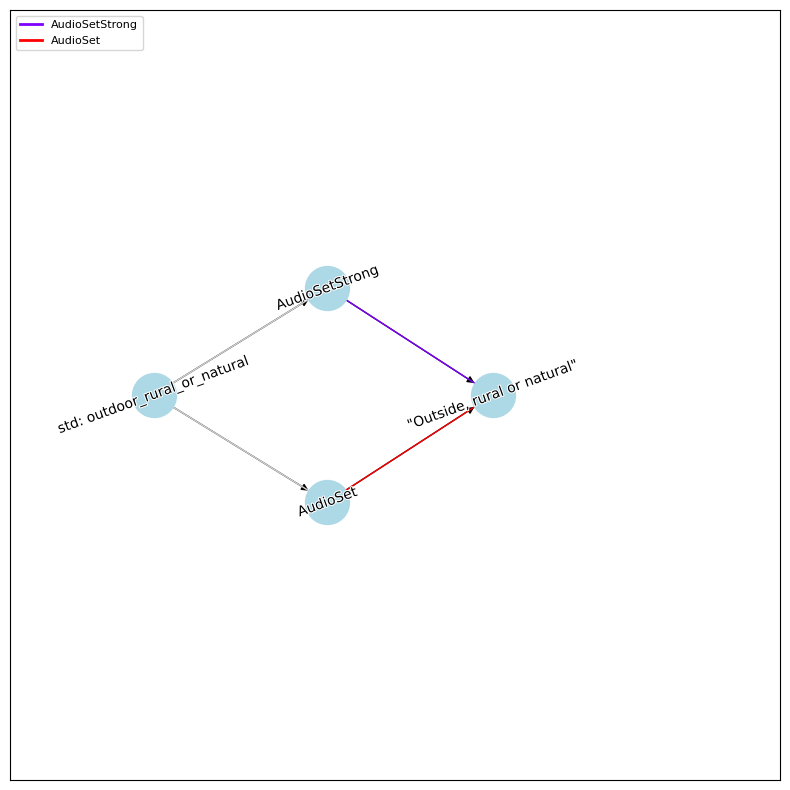

--------------------------------------------------------------------------------------
STANDARD LABEL: outdoor_urban_or_manmade

AudioSet DATASET
['Outside, urban or manmade', 'Traffic noise, roadway noise']

Freesound50k DATASET
['Traffic_noise_and_roadway_noise']

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
No Correlation



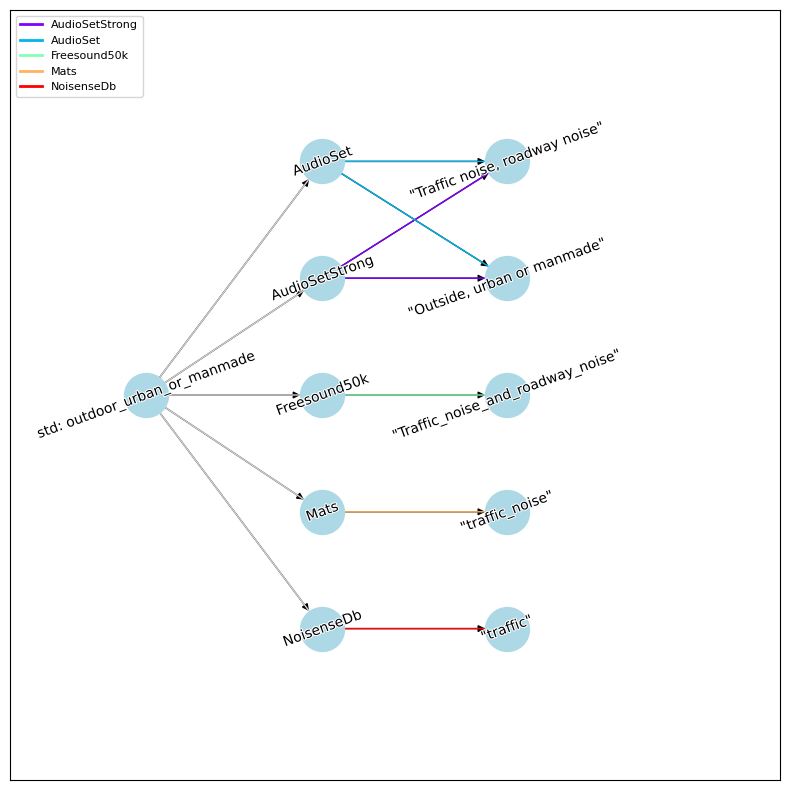

--------------------------------------------------------------------------------------
STANDARD LABEL: car_alarm_ringing

AudioSet DATASET
['Car alarm']

Freesound50k DATASET
No Correlation

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
No Correlation



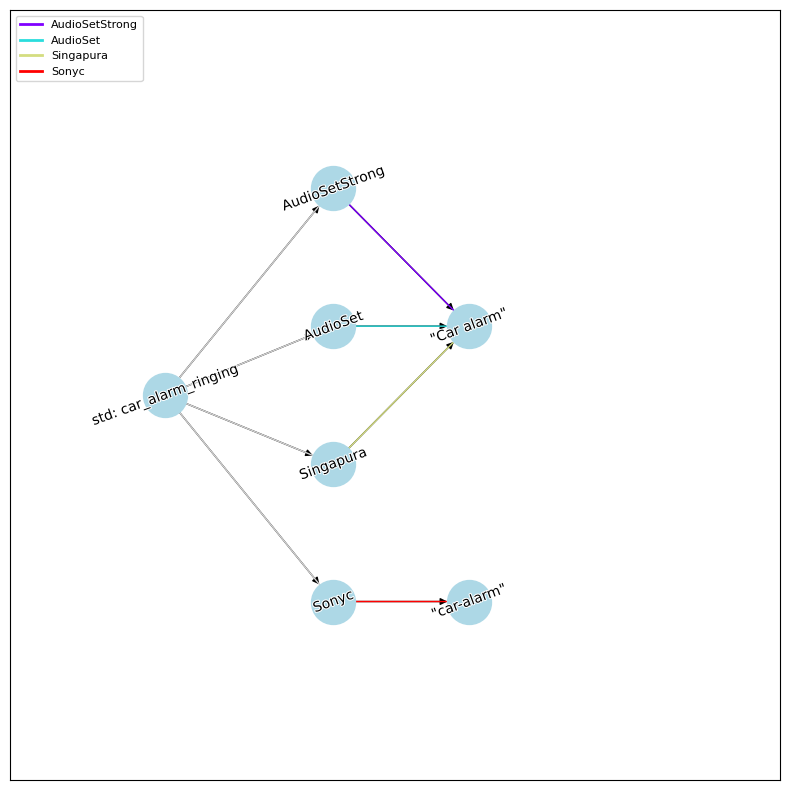

--------------------------------------------------------------------------------------
STANDARD LABEL: car_horn

AudioSet DATASET
['Toot', 'Vehicle horn, car horn, honking']

Freesound50k DATASET
['Vehicle_horn_and_car_horn_and_honking']

UrbanSound8k DATASET
['car_horn']

ESC-50 DATASET
['car_horn']



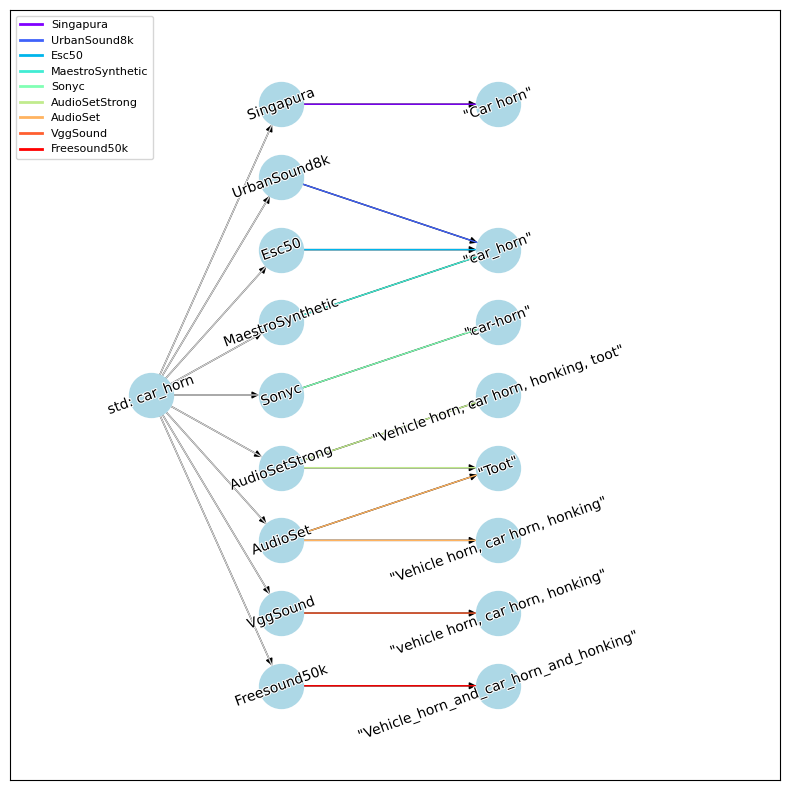

--------------------------------------------------------------------------------------
STANDARD LABEL: bicycle_bell

AudioSet DATASET
['Bicycle bell']

Freesound50k DATASET
['Bicycle_bell']

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
No Correlation



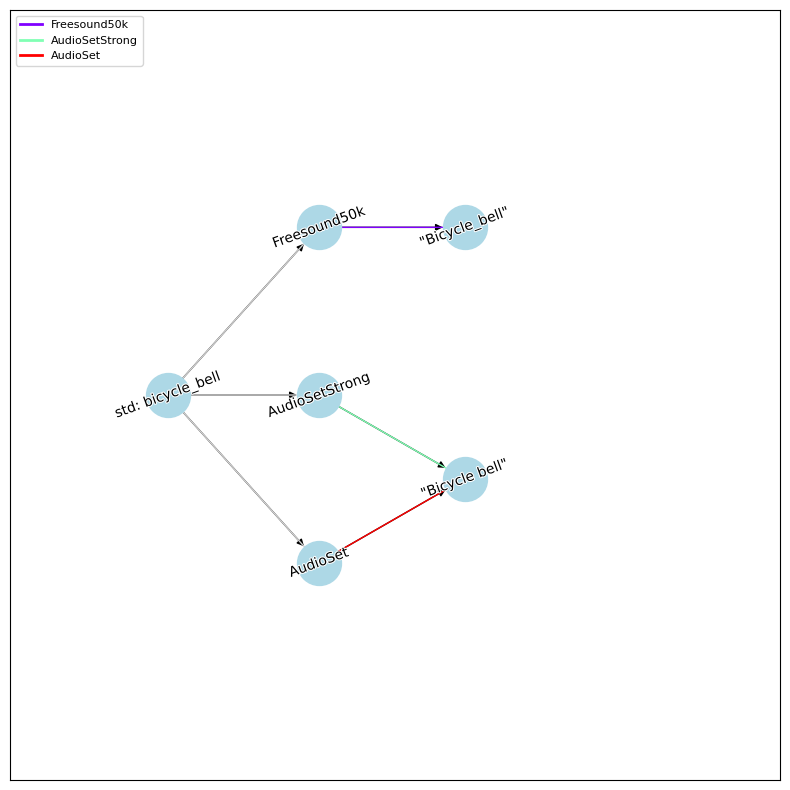

--------------------------------------------------------------------------------------
STANDARD LABEL: train_horn

AudioSet DATASET
['Train horn']

Freesound50k DATASET
No Correlation

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
No Correlation



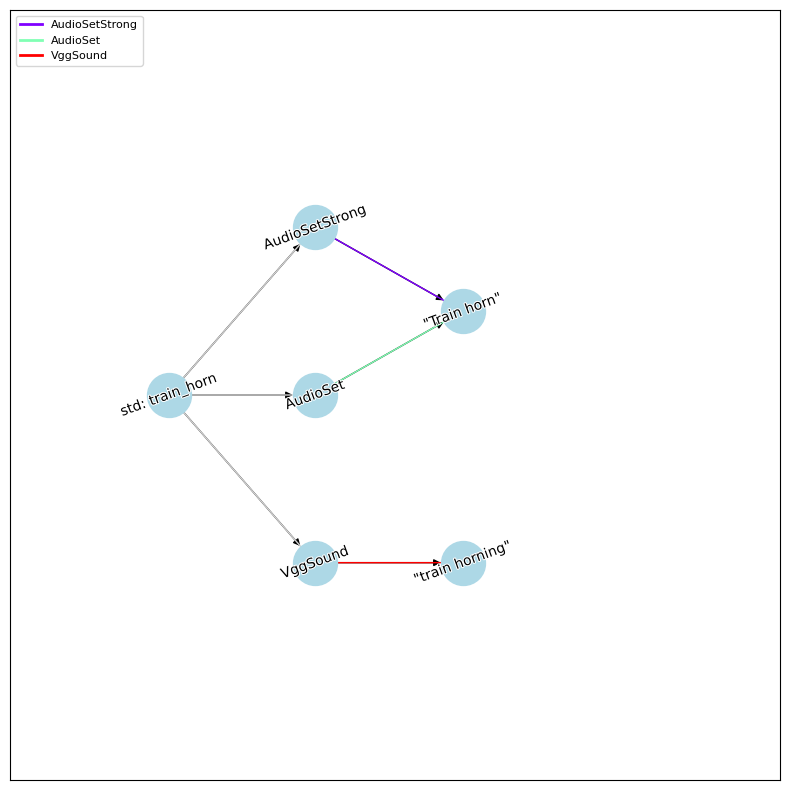

--------------------------------------------------------------------------------------
STANDARD LABEL: train_whistle

AudioSet DATASET
['Train whistle']

Freesound50k DATASET
No Correlation

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
No Correlation



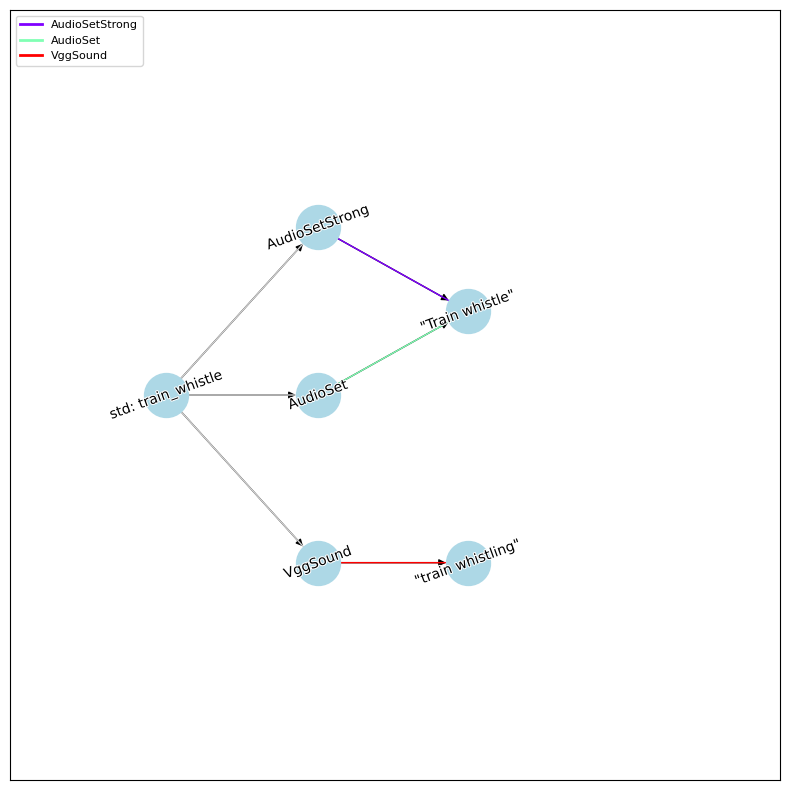

--------------------------------------------------------------------------------------
STANDARD LABEL: foghorn_ringing

AudioSet DATASET
['Foghorn']

Freesound50k DATASET
No Correlation

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
No Correlation



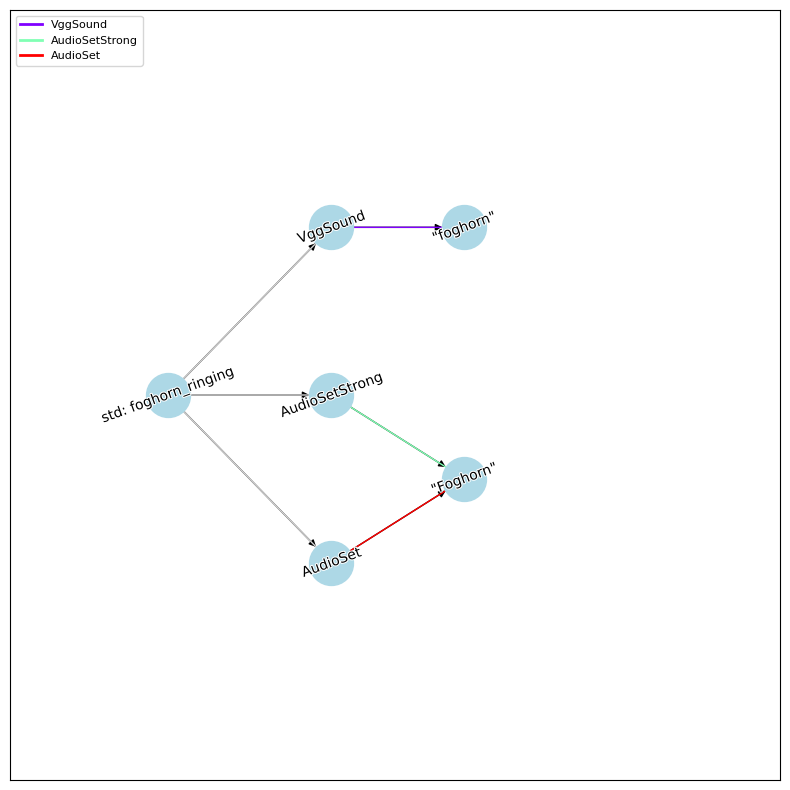

--------------------------------------------------------------------------------------
STANDARD LABEL: car_horn

AudioSet DATASET
['Toot', 'Vehicle horn, car horn, honking']

Freesound50k DATASET
['Vehicle_horn_and_car_horn_and_honking']

UrbanSound8k DATASET
['car_horn']

ESC-50 DATASET
['car_horn']



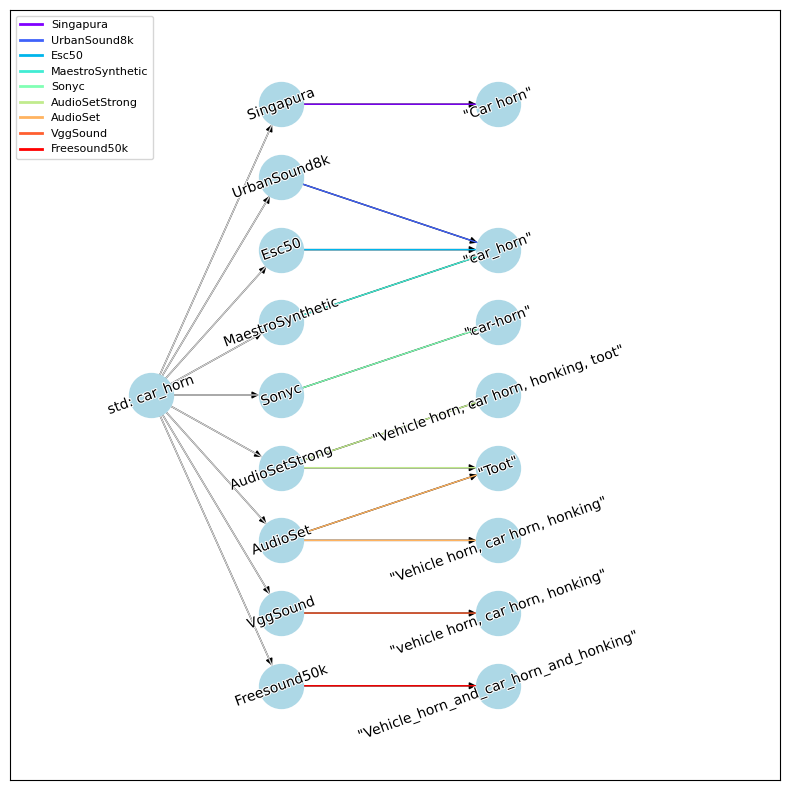

--------------------------------------------------------------------------------------
STANDARD LABEL: reverse_beeper

AudioSet DATASET
['Reversing beeps']

Freesound50k DATASET
No Correlation

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
No Correlation



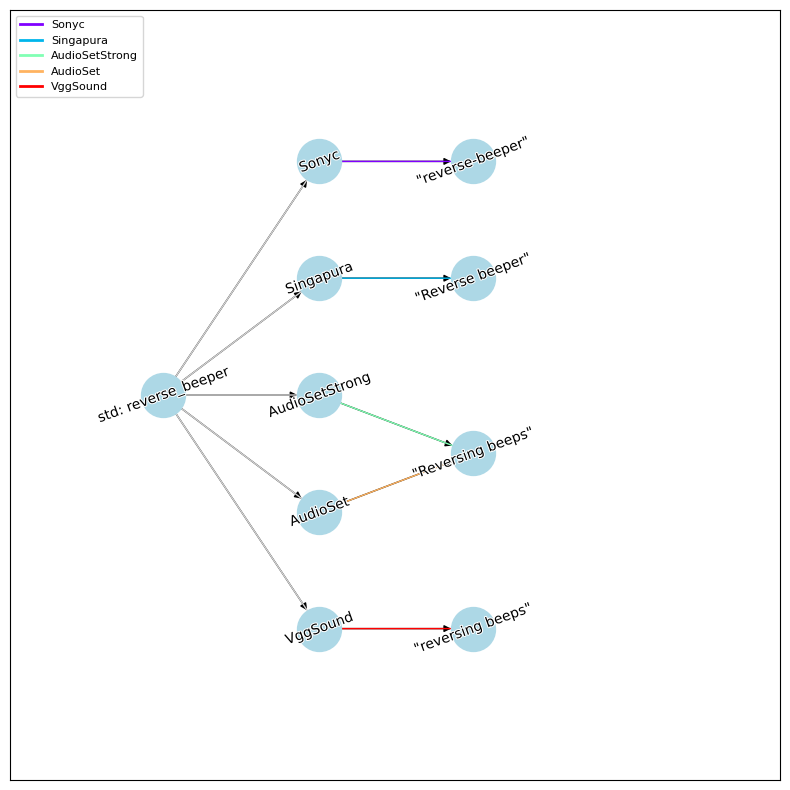

--------------------------------------------------------------------------------------
STANDARD LABEL: bleep_bleep

AudioSet DATASET
['Beep, bleep']

Freesound50k DATASET
No Correlation

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
No Correlation



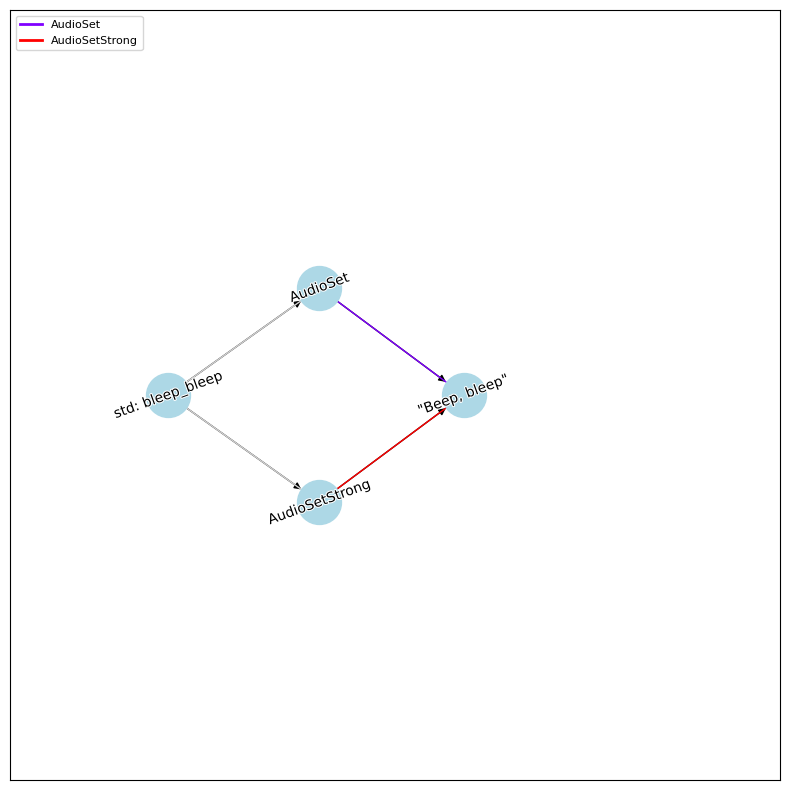

--------------------------------------------------------------------------------------
STANDARD LABEL: civil_defense_siren_ringing

AudioSet DATASET
['Civil defense siren']

Freesound50k DATASET
No Correlation

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
No Correlation



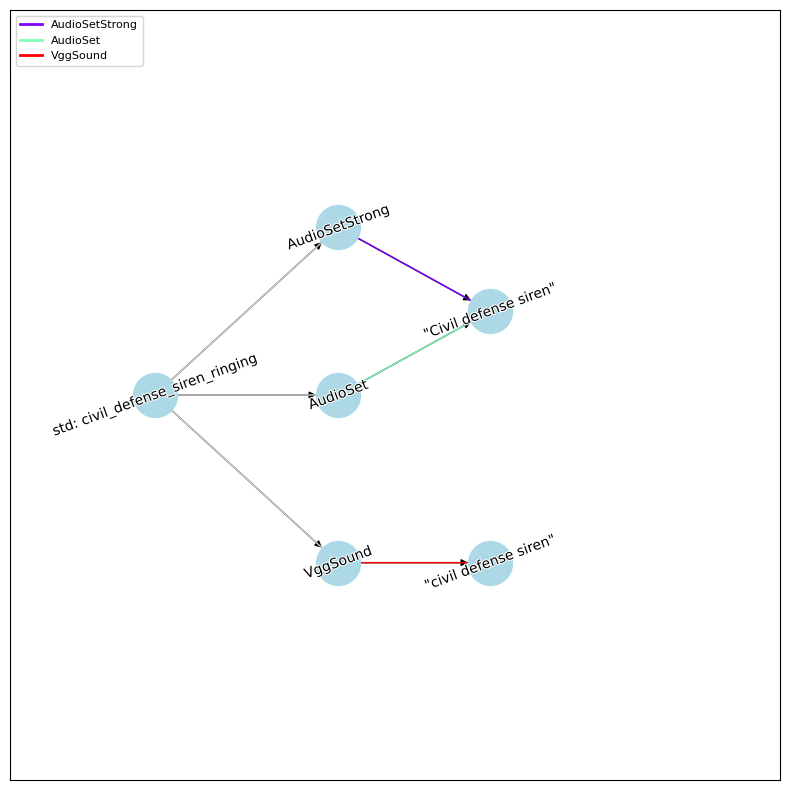

--------------------------------------------------------------------------------------
STANDARD LABEL: alarm_signal

AudioSet DATASET
['Alarm',
 'Fire alarm',
 'Smoke detector, smoke alarm',
 'Alarm clock',
 'Car alarm',
 'Buzzer',
 'Foghorn',
 'Whistle',
 'Kettle whistle',
 'Steam whistle',
 'Bicycle bell',
 'Air horn, truck horn',
 'Toot',
 'Vehicle horn, car horn, honking',
 'Telephone',
 'Telephone dialing, DTMF',
 'Telephone bell ringing',
 'Busy signal',
 'Dial tone',
 'Siren',
 'Civil defense siren',
 'Police car (siren)',
 'Ambulance (siren)',
 'Fire engine, fire truck (siren)',
 'Reversing beeps',
 'Doorbell',
 'Ding-dong',
 'Ringtone']

Freesound50k DATASET
['Alarm',
 'Bicycle_bell',
 'Vehicle_horn_and_car_horn_and_honking',
 'Telephone',
 'Siren',
 'Doorbell',
 'Ringtone']

UrbanSound8k DATASET
['car_horn', 'siren']

ESC-50 DATASET
['clock_alarm', 'car_horn', 'siren']



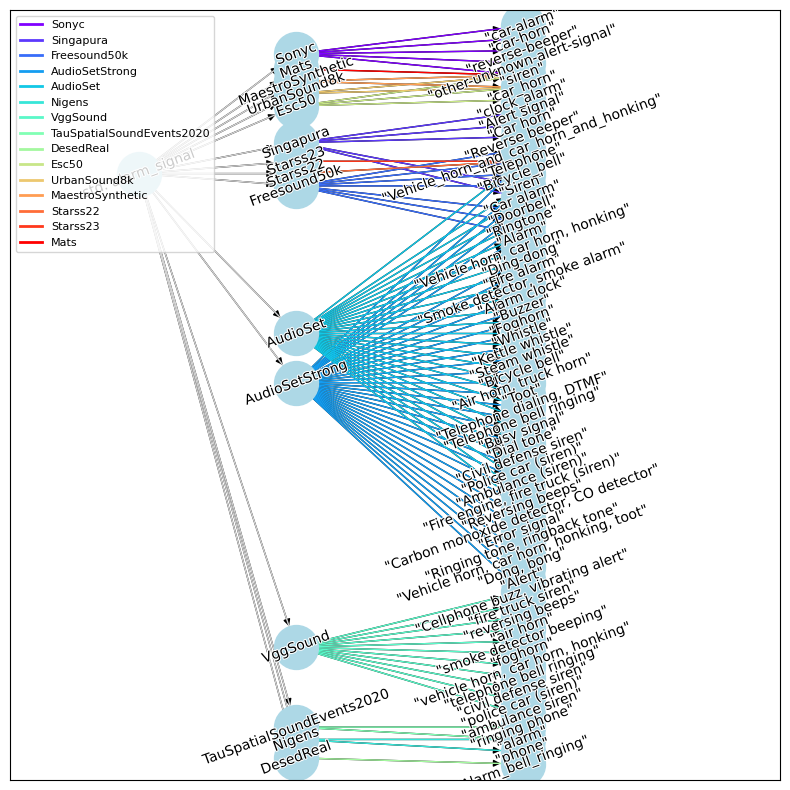

--------------------------------------------------------------------------------------
STANDARD LABEL: smoke_alarm

AudioSet DATASET
['Smoke detector, smoke alarm']

Freesound50k DATASET
No Correlation

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
No Correlation



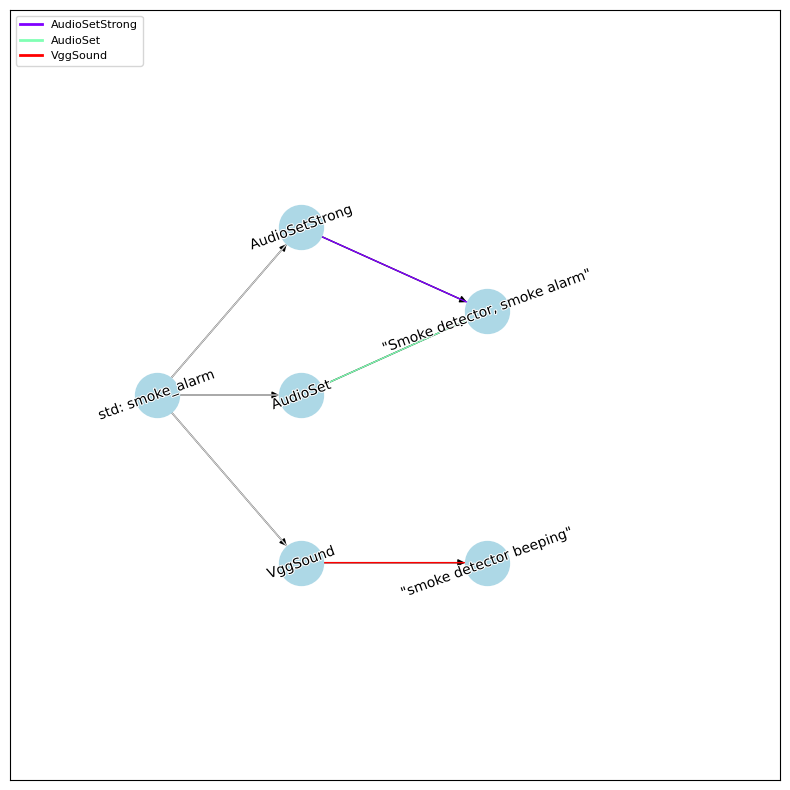

--------------------------------------------------------------------------------------
STANDARD LABEL: fire_alarm_ringing

AudioSet DATASET
['Fire alarm', 'Smoke detector, smoke alarm']

Freesound50k DATASET
No Correlation

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
No Correlation



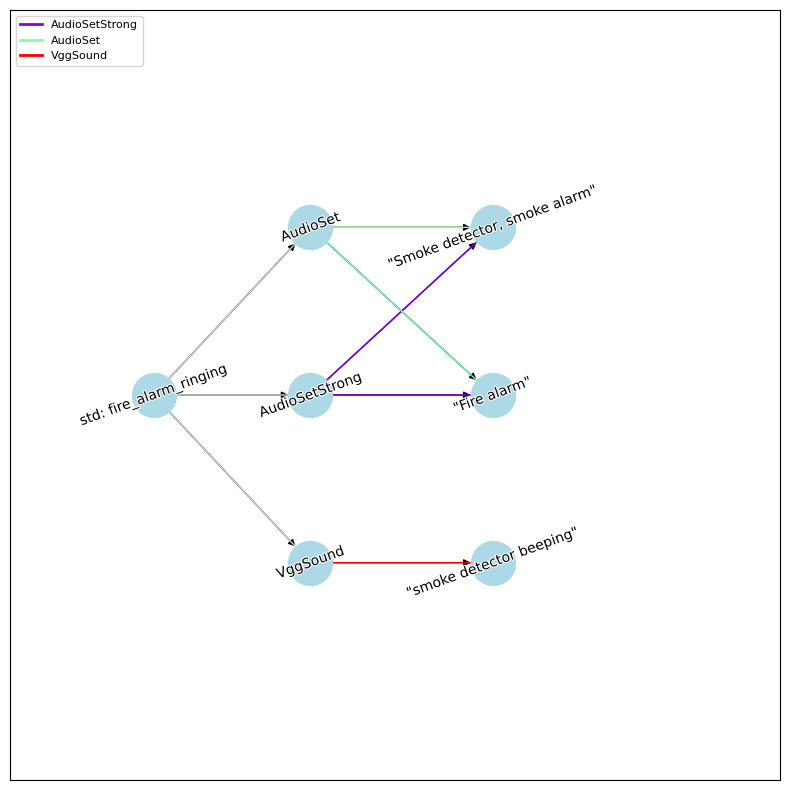

--------------------------------------------------------------------------------------
STANDARD LABEL: buzzer_ringing

AudioSet DATASET
['Buzzer']

Freesound50k DATASET
No Correlation

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
No Correlation



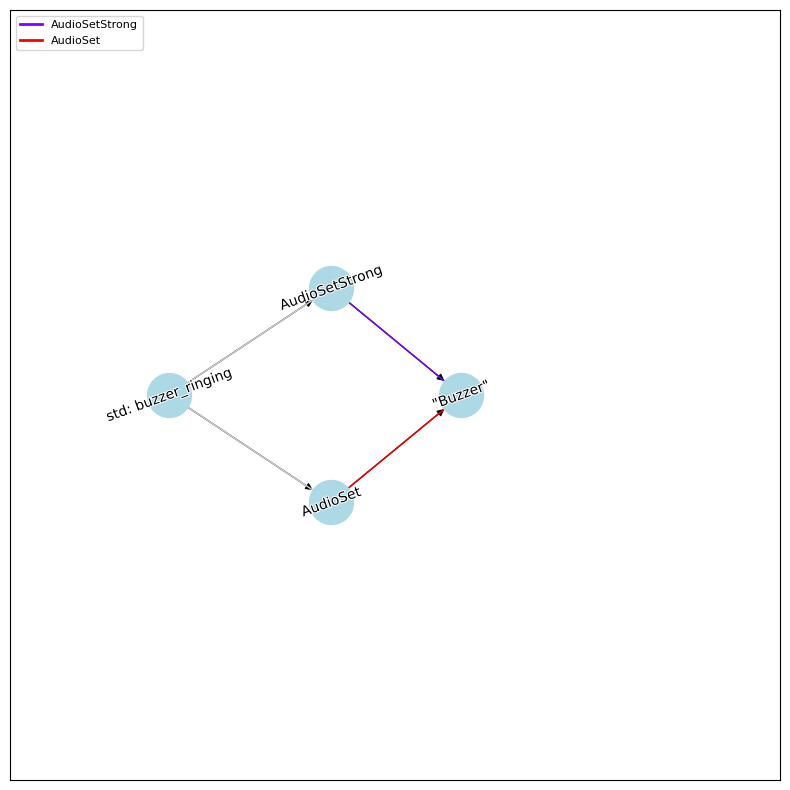

--------------------------------------------------------------------------------------
STANDARD LABEL: speech

AudioSet DATASET
['Chatter',
 'Child speech, kid speaking',
 'Conversation',
 'Female speech, woman speaking',
 'Male speech, man speaking',
 'Narration, monologue',
 'Speech',
 'Speech synthesizer']

Freesound50k DATASET
['Chatter',
 'Child_speech_and_kid_speaking',
 'Conversation',
 'Female_speech_and_woman_speaking',
 'Male_speech_and_man_speaking',
 'Speech',
 'Speech_synthesizer']

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
No Correlation



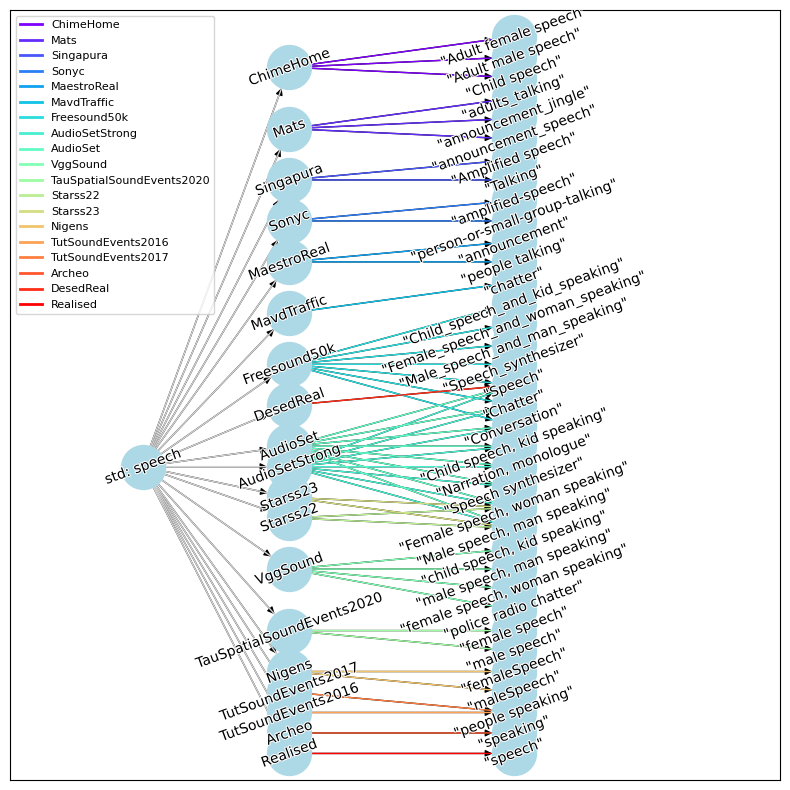

--------------------------------------------------------------------------------------
STANDARD LABEL: music

AudioSet DATASET
['A capella',
 'Accordion',
 'Acoustic guitar',
 'Afrobeat',
 'Alto saxophone',
 'Ambient music',
 'Angry music',
 'Background music',
 'Bagpipes',
 'Banjo',
 'Bass drum',
 'Bass guitar',
 'Bassline',
 'Bassoon',
 'Beat',
 'Beatboxing',
 'Bell',
 'Birthday music',
 'Bluegrass',
 'Blues',
 'Bowed string instrument',
 'Brass instrument',
 'Bugle',
 'Carnatic music',
 'Cello',
 'Chant',
 'Chime',
 'Choir',
 'Chord',
 'Christian music',
 'Christmas music',
 'Church bell',
 'Clarinet',
 'Classical music',
 'Clavinet',
 'Cornet',
 'Country',
 'Cowbell',
 'Crash cymbal',
 'Cumbia',
 'Cymbal',
 'Dance music',
 'Didgeridoo',
 'Disco',
 'Double bass',
 'Drone',
 'Drone music',
 'Drum',
 'Drum and bass',
 'Drum beat',
 'Drum kit',
 'Drum machine',
 'Drum roll',
 'Dub',
 'Dubstep',
 'Electric guitar',
 'Electric piano',
 'Electro',
 'Electronic dance music',
 'Electronic m

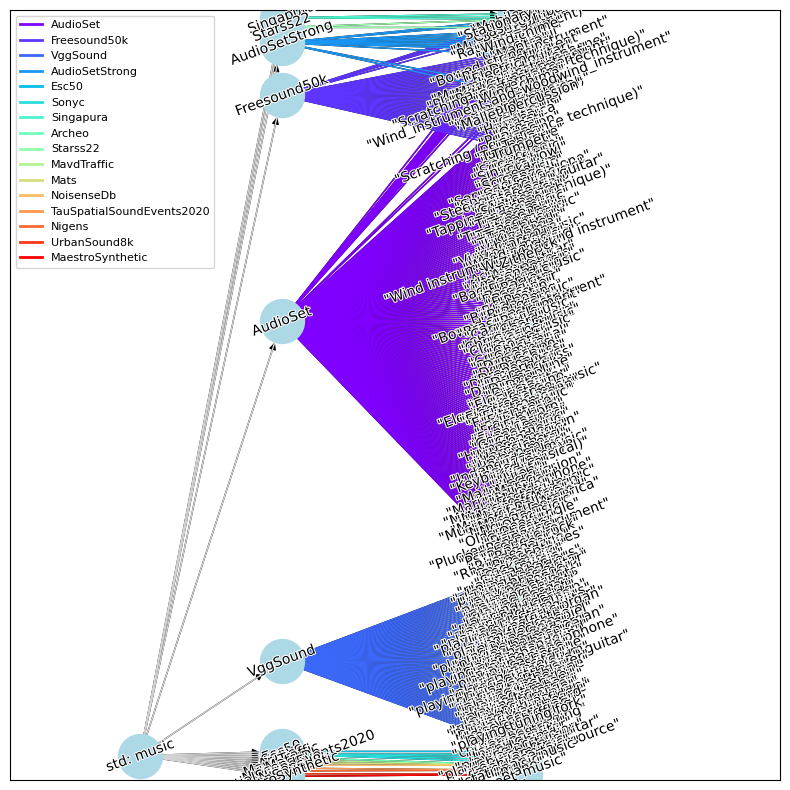

--------------------------------------------------------------------------------------
STANDARD LABEL: singing

AudioSet DATASET
['A capella',
 'Chant',
 'Child singing',
 'Choir',
 'Female singing',
 'Male singing',
 'Mantra',
 'Rapping',
 'Singing',
 'Synthetic singing',
 'Vocal music',
 'Yodeling']

Freesound50k DATASET
['Female_singing', 'Male_singing', 'Singing']

UrbanSound8k DATASET
No Correlation

ESC-50 DATASET
No Correlation



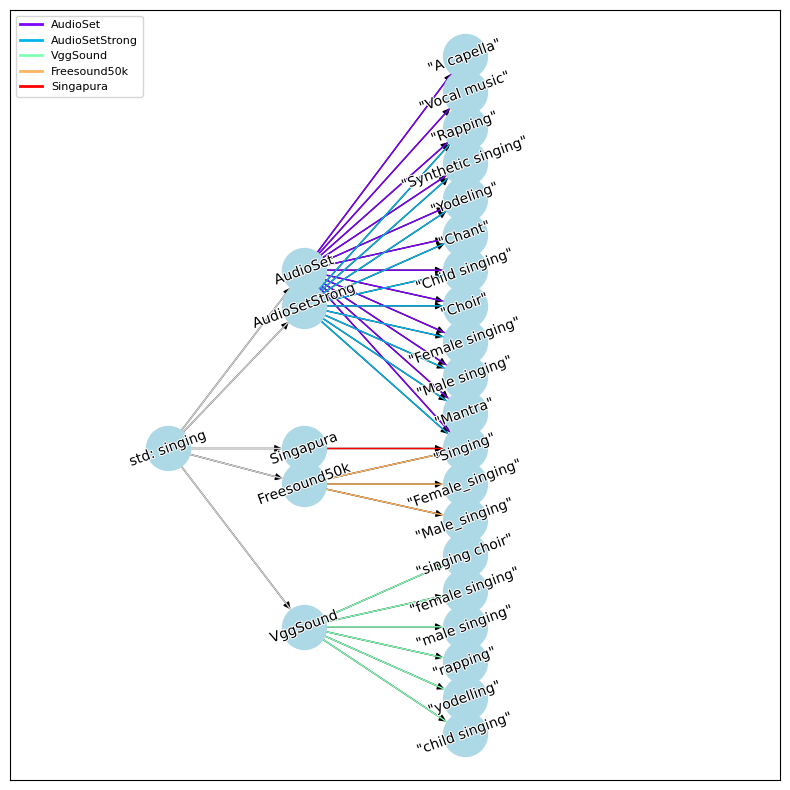

--------------------------------------------------------------------------------------
STANDARD LABEL: engine

AudioSet DATASET
['Accelerating, revving, vroom',
 'Car passing by',
 'Chainsaw',
 "Dental drill, dentist's drill",
 'Engine',
 'Engine knocking',
 'Engine starting',
 'Heavy engine (low frequency)',
 'Idling',
 'Lawn mower',
 'Light engine (high frequency)',
 'Medium engine (mid frequency)',
 'Race car, auto racing',
 'Sewing machine',
 'Aircraft engine',
 'Propeller, airscrew',
 'Jet engine']

Freesound50k DATASET
['Accelerating_and_revving_and_vroom',
 'Car_passing_by',
 'Engine',
 'Engine_starting',
 'Idling',
 'Race_car_and_auto_racing']

UrbanSound8k DATASET
['engine_idling']

ESC-50 DATASET
['chainsaw', 'engine']



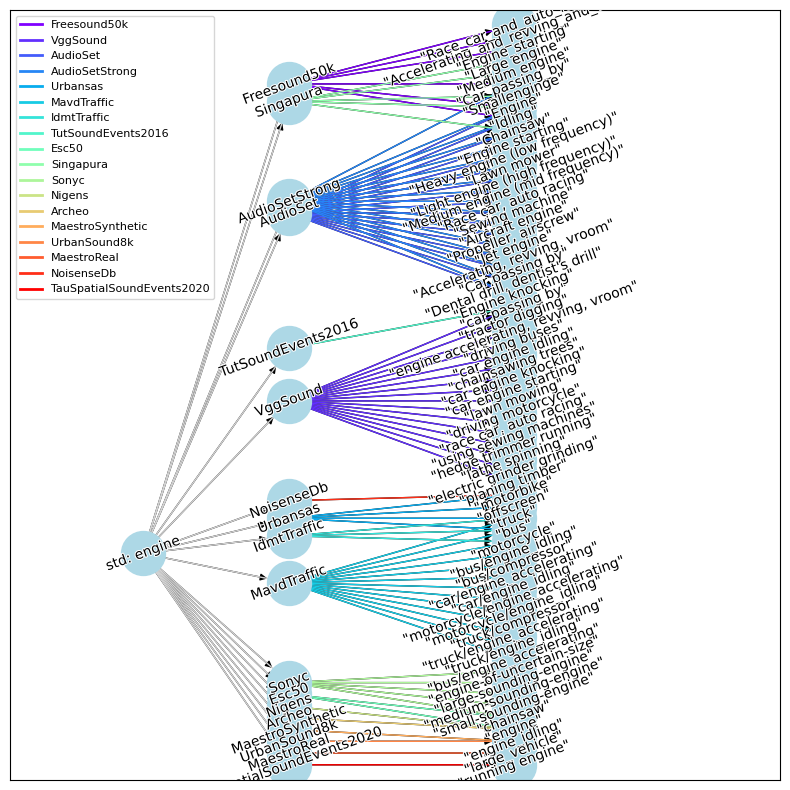

--------------------------------------------------------------------------------------


In [ ]:
for label in negatives:
    dictionary = e.get_mapping_for_dataset_label(label)
    std_label = e.get_std_label_from_dataset_label(label)
    print(f'STANDARD LABEL: {std_label}')
    print()

    print('AudioSet DATASET')
    pp(dictionary['AudioSet'])
    print()
    print('Freesound50k DATASET')
    try:
        pp(dictionary['Freesound50k'])
    except:
        print('No Correlation')

    print()
    print('UrbanSound8k DATASET')
    try:
        pp(dictionary['UrbanSound8k'])
    except:
        print('No Correlation')

    print()
    print('ESC-50 DATASET')
    try:
        pp(dictionary['Esc50'])
    except:
        print('No Correlation')

    print()
    e.plot_std_label_mapping(std_label)
    print('--------------------------------------------------------------------------------------')

# Dataset Comparison Histograms

In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
dataset_names = ['AudioSet-EV', 'ESC-50', 'SireNNet', 'LSSiren', 'UrbanSound8K', 'Freesound50K']
overall_positive_samps = [8409, 40, 1254, 932, 929, 133]
overall_negative_samps = [1794186, 320, 421, 902, 7803, 21844]
pos_balanced = 8409
neg_balanced = 8501

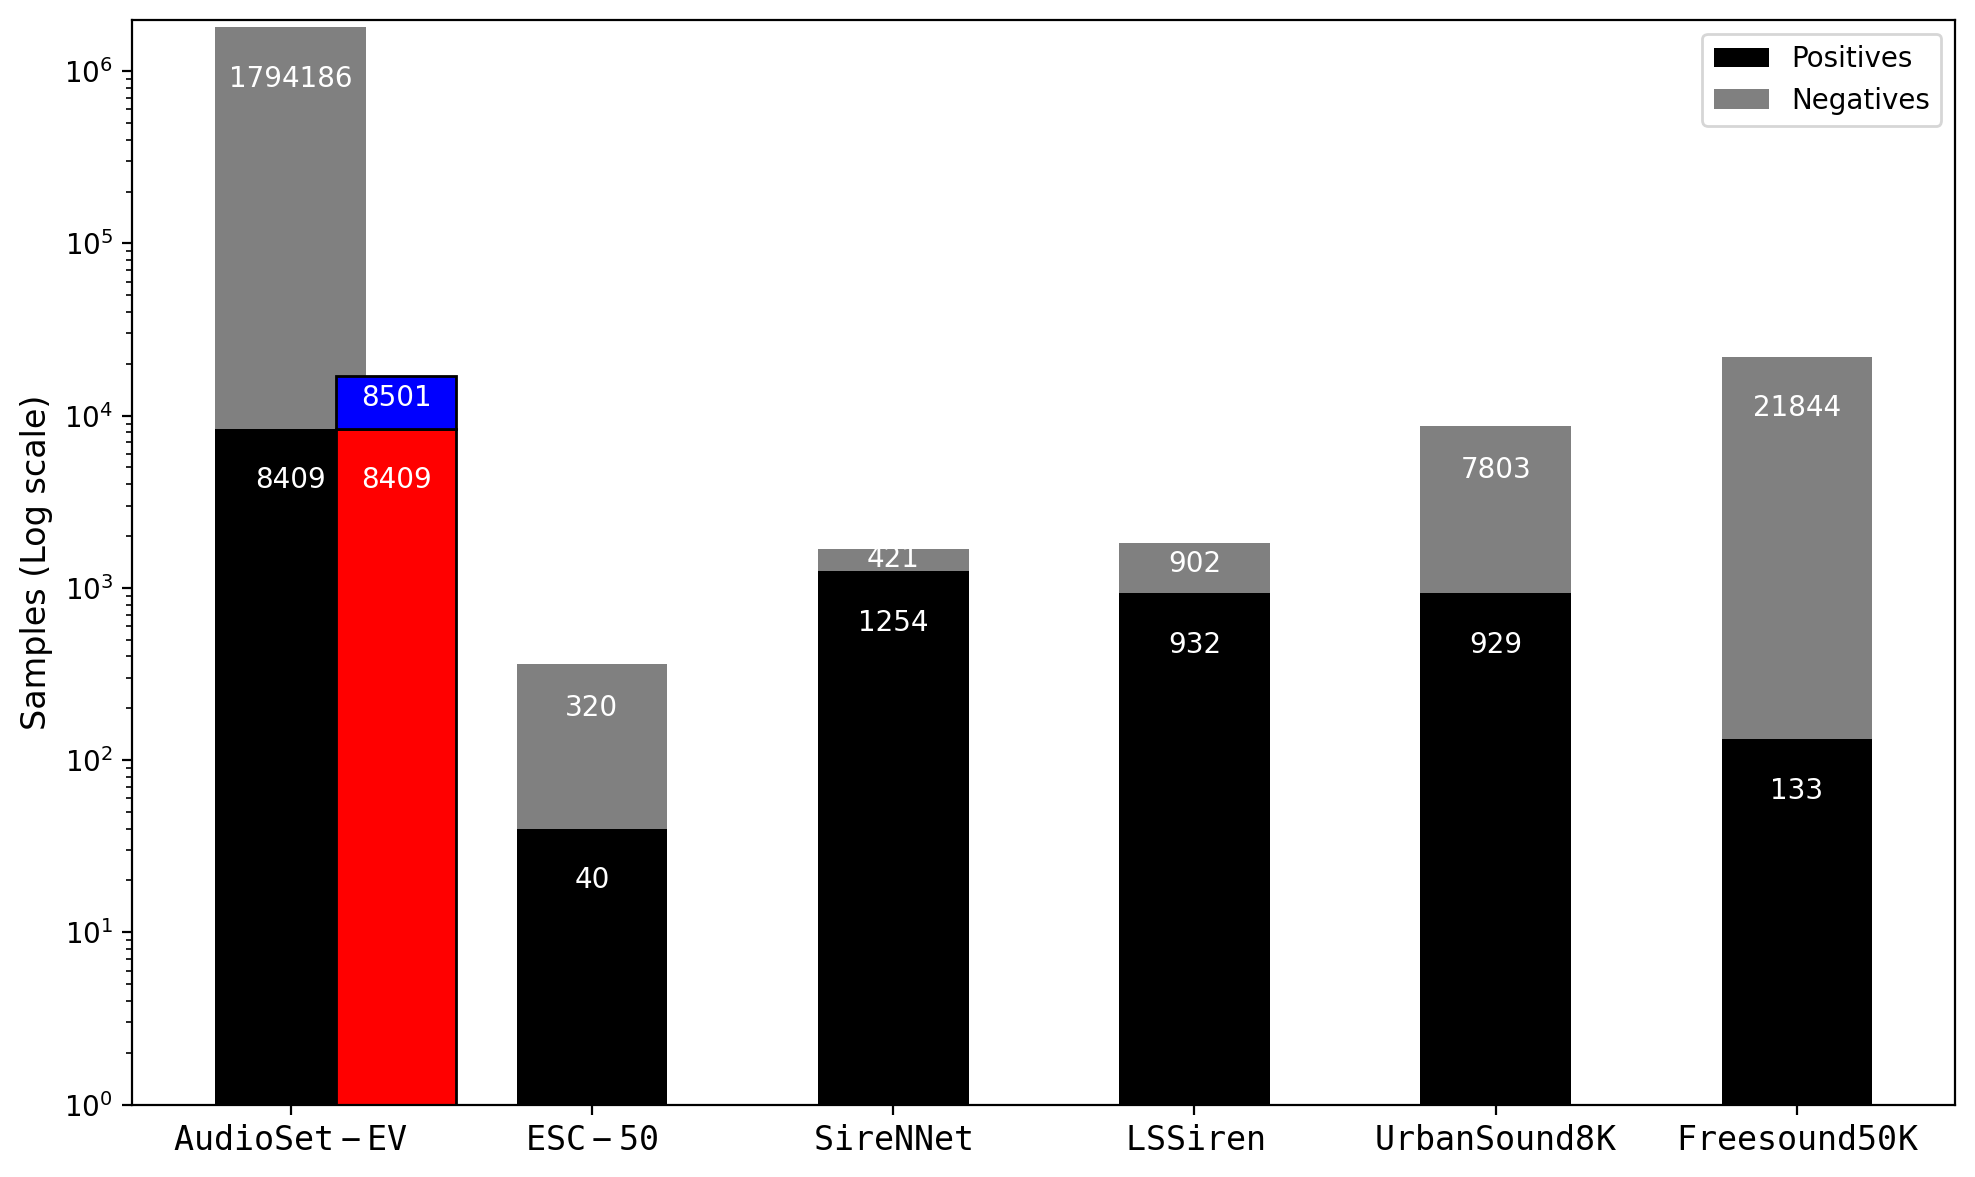

In [ ]:
def plot_dataset_comparison(dataset_names, overall_positive_samps, overall_negative_samps, save_fig=False, fig_name="dataset_comparison.png"):
    """
    Creates a stacked bar plot for EV datasets, where each dataset is represented by a single bar
    composed of two segments: the lower (black) segment represents the number of positive samples,
    and the upper (grey) segment represents the number of negative samples. The overall height of the bar
    equals the total number of samples in the dataset.

    Additionally, for the AudioSet-EV dataset (the post-balancing version), a separate stacked bar is added
    nearby in red and blue. In this bar, the lower segment (red) represents the balanced number of positive
    samples and the upper segment (blue) represents the balanced number of negative samples.

    Parameters:
        dataset_names (list of str): Names of the datasets.
        overall_positive_samps (list of int): Number of positive samples for each dataset.
        overall_negative_samps (list of int): Number of negative samples for each dataset.
        save_fig (bool): If True, the figure is saved as both a PNG and an SVG.
        fig_name (str): The filename for the saved PNG (the SVG will use the same base name).
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Format dataset names using pseudo-LaTeX monospaced font
    labels_formatted = [r"$\mathtt{" + name.replace(" ", "~") + "}$" for name in dataset_names]

    # x positions for each dataset
    x = np.arange(len(dataset_names))
    bar_width = 0.5

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the positives (lower segment) as black bars
    ax.bar(x, overall_positive_samps, width=bar_width, color="black", label="Positives")
    # Plot the negatives (upper segment) as grey bars stacked on top of positives
    ax.bar(x, overall_negative_samps, width=bar_width, bottom=overall_positive_samps, color="grey", label="Negatives")

    # Set the y-axis to a logarithmic scale (base 10)
    ax.set_yscale("log", base=10)
    ax.set_xticks(x)
    ax.set_xticklabels(labels_formatted, fontsize=12)
    ax.set_ylabel("Samples (Log scale)", fontsize=12)
    ax.legend(loc='best')

    # Annotate each bar segment with its sample count, centered vertically in each segment
    for i in range(len(x)):
        pos_val = overall_positive_samps[i]
        neg_val = overall_negative_samps[i]
        if pos_val > 0:
            ax.text(x[i], pos_val / 2, str(pos_val), ha='center', va='center', fontsize=10, color="white")
        if neg_val > 0:
            ax.text(x[i], pos_val + neg_val / 2, str(neg_val), ha='center', va='center', fontsize=10, color="white")

    # For AudioSet-EV, add a separate post-balancing stacked bar (in red and blue) near its original bar
    if "AudioSet-EV" in dataset_names:
        idx = dataset_names.index("AudioSet-EV")
        # Post-balancing values
        pos_balanced = 8409
        neg_balanced = 8501
        # Offset x position for the balanced bar (to the right of the original AudioSet-EV bar)
        offset_x = 0.35
        balanced_x = x[idx] + offset_x
        balanced_bar_width = bar_width * 0.8  # Make it slightly thinner

        # Plot the balanced positives (red) as the lower segment
        ax.bar(balanced_x, pos_balanced, width=balanced_bar_width, color="red", edgecolor="black",
               label="Balanced Positives")
        # Plot the balanced negatives (blue) stacked on top of balanced positives
        ax.bar(balanced_x, neg_balanced, width=balanced_bar_width, bottom=pos_balanced, color="blue", edgecolor="black",
               label="Balanced Negatives")

        # Annotate the balanced positives and negatives
        if pos_balanced > 0:
            ax.text(balanced_x, pos_balanced / 2, str(pos_balanced), ha='center', va='center', fontsize=10, color="white")
        if neg_balanced > 0:
            ax.text(balanced_x, pos_balanced + neg_balanced / 2, str(neg_balanced), ha='center', va='center', fontsize=10, color="white")

    # Set y-axis limit: ensure an upper limit of at least 1000 or 10% above the maximum total count
    max_count = max([p + n for p, n in zip(overall_positive_samps, overall_negative_samps)])
    ax.set_ylim(1, max(1000, max_count * 1.1))

    plt.tight_layout()

    if save_fig:
        png_path = fig_name
        svg_path = fig_name.replace(".png", ".svg")
        plt.savefig(png_path, dpi=600)
        plt.savefig(svg_path, format='svg')

    plt.show()

plot_dataset_comparison(dataset_names, overall_positive_samps, overall_negative_samps, save_fig=True)